This notebook demonstrates several types of distributional evaluation for a basic recommendation experiment on the MovieLens 1M data set.  We are using 1M instead of one of the newer and larger ones so that we have user demographics for the disaggregated segments of the evaluation.

## Environment and Data

### Software Environment

We're going to start by importing the software packages we need. Python stdlib packages:


In [1]:
from pathlib import Path

PyData packages:


In [2]:
import pandas as pd
import numpy as np
import xarray as xa
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as sps
import plotnine as pn

LensKit packages:


In [3]:
from lenskit import topn
from lkdemo.metrics import rbp

Local code:


In [4]:
from lkdemo.plotutils import *
from eval_tables import EvalTable
from IPython.display import HTML

Set up progress and logging output:


In [5]:
from tqdm.auto import tqdm
import logging
import lenskit.util

_log = logging.getLogger('notebook')
lenskit.util.log_to_notebook()
tqdm.pandas()

[   INFO] lenskit.util.log notebook logging configured


Where do we want output?


In [6]:
fig_dir = init_figs('UserDists')
print(fig_dir)

using figure dir figures/UserDists
figures/UserDists


### Loading Data

Now let's load the MovieLens data and recommendation outputs.

First the test data:


In [7]:
test_dir = Path('data-split/ml1m/')
test = pd.read_parquet(test_dir / 'test-1.parquet')
test.head()

,user,item,rating,timestamp
index,,,,
453,6,1101,4.0,978236670
452,6,2406,5.0,978236670
509,6,1806,3.0,978236876
502,6,3699,4.0,978236567
480,6,1569,4.0,978238948


Now let's load the user data:


In [8]:
ml_dir = Path('data/ml-1m/')
users = pd.read_table(ml_dir / 'users.dat', sep='::', names=['user', 'gender', 'age', 'occ', 'zip'], engine='python')
users.set_index('user', inplace=True)
users.head()

,gender,age,occ,zip
user,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


And the recommendations:


In [9]:
run_dir = Path('runs/')
recs = {}
for rf in run_dir.glob('ml1m-*/recs-1.parquet'):
    rdname = rf.parent.name
    algo = rdname[len('ml1m-'):]
    recs[algo] = pd.read_parquet(rf)
recs = pd.concat(recs, names=['algo'])
recs = recs.reset_index('algo').reset_index(drop=True)
recs.algo = recs.algo.astype('category').cat.rename_categories({'III': 'IKNN'})
recs.head()

,algo,item,score,user,rank
0,IKNN,1265,9.752318,6,1
1,IKNN,1196,9.746611,6,2
2,IKNN,1270,9.562931,6,3
3,IKNN,356,9.534776,6,4
4,IKNN,919,9.496835,6,5


List of algorithms:


In [10]:
algos = ['IALS', 'IKNN', 'Pop']

And some quick stats.


In [11]:
n_users = recs['user'].nunique()
n_users

1500

In [12]:
g_nu = users.loc[recs['user'].unique(), 'gender'].value_counts()
g_nu

M    1086
F     414
Name: gender, dtype: int64

### Computing Metrics

Now that the recommendations are loaded, let's compute some top-*N* performance metrics:


In [13]:
rla = topn.RecListAnalysis()
rla.add_metric(rbp, k=1000)
rla.add_metric(rbp, k=1000, patience=0.5, name='rbp05')
rla.add_metric(topn.hit, k=1000)
rla.add_metric(topn.hit, name='hit10', k=10)
rla.add_metric(topn.hit, name='hit20', k=20)
rla.add_metric(topn.ndcg, k=1000)
rla.add_metric(topn.recip_rank, k=1000)

In [14]:
user_scores = rla.compute(recs, test, include_missing=True)
user_scores.head()

[   INFO] lenskit.topn analyzing 4500000 recommendations (7500 truth rows)


[   INFO] lenskit.topn using rec key columns ['algo', 'user']


[   INFO] lenskit.topn using truth key columns ['user']


[   INFO] lenskit.topn numbering truth lists


[   INFO] lenskit.topn numbering rec lists


[   INFO] lenskit.topn collecting metric results


[   INFO] lenskit.topn measured 4500 lists in 2.48s


[   INFO] lenskit.topn filling in missing user info (4500 initial rows)


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/lenskit/topn.py:152: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.


nrecs           rbp         rbp05  hit  hit10  hit20      ndcg  \
algo user                                                                   
IALS 6      1000  2.370747e-03  4.768444e-07  1.0    0.0    1.0  0.216322   
     8      1000  1.025588e-01  6.250000e-02  1.0    1.0    1.0  0.351671   
     10     1000  4.789049e-07  1.734723e-18  1.0    0.0    0.0  0.173779   
     11     1000  9.211196e-06  1.421259e-14  1.0    0.0    0.0  0.206625   
     13     1000  3.044759e-02  9.784698e-04  1.0    1.0    1.0  0.281993   

           recip_rank  ntruth  
algo user                      
IALS 6       0.050000       5  
     8       0.333333       5  
     10      0.017241       5  
     11      0.022222       5  
     13      0.111111       5

In [15]:
user_scores.drop(columns=['nrecs', 'ntruth'], inplace=True)
user_scores.fillna(0, inplace=True)

In [16]:
agg_names = {
    'hit': 'HR',
    'hit10': 'HR@10',
    'hit20': 'HR@20',
    'ndcg': 'nDCG',
    'recip_rank': 'MRR',
    'rbp': 'RBP',
}

## First-Order Analysis

What results would we display in a traditional analysis?

Let's start with a table of mean scores:


In [17]:
algo_scores = user_scores.groupby('algo').mean()
algo_scores.rename(columns=agg_names, inplace=True)
as_styled = algo_scores.style.highlight_max(props='font-weight: bold')
as_styled.to_latex(fig_dir / 'metric-point-estimates.tex')
as_styled

,RBP,rbp05,HR,HR@10,HR@20,nDCG,MRR
algo,,,,,,,
IALS,0.061390,0.045218,1.000000,0.494667,0.680667,0.286168,0.223139
IKNN,0.057128,0.051729,1.000000,0.448000,0.594000,0.261441,0.237165
Pop,0.035225,0.030296,0.996000,0.302000,0.452000,0.210809,0.154980


Let's significance-test these.


In [18]:
pd.Series({
    m: stats.ttest_rel(user_scores.loc['IALS', m], user_scores.loc['IKNN', m]).pvalue
    for m in user_scores.columns
})

rbp           7.146337e-02
rbp05         2.988607e-02
hit                    NaN
hit10         4.761841e-03
hit20         2.714211e-08
ndcg          9.466363e-11
recip_rank    1.718026e-01
dtype: float64

We can also show this as a bar chart with confidence intervals (here computed by Seaborn as a 95% bootstrapped CI):


In [19]:
us_tall = user_scores.reset_index().melt(id_vars=['algo', 'user'], var_name='metric')
us_tall.head()

,algo,user,metric,value
0,IALS,6,rbp,2.370747e-03
1,IALS,8,rbp,1.025588e-01
2,IALS,10,rbp,4.789049e-07
3,IALS,11,rbp,9.211196e-06
4,IALS,13,rbp,3.044759e-02


In [20]:
us_tall['metric'] = us_tall['metric'].astype('category').cat.rename_categories(agg_names)

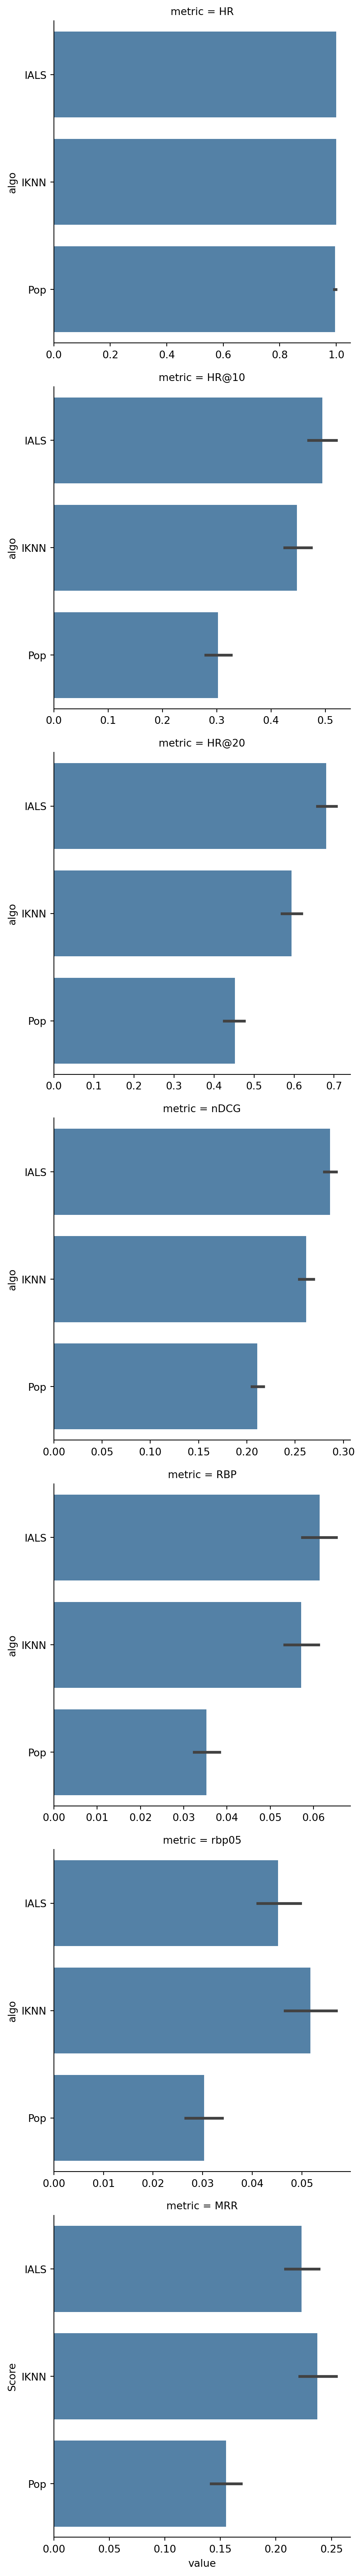

In [21]:
sns.catplot(us_tall, x='value', y='algo', row='metric', kind='bar', sharex=False, color='steelblue')
plt.ylabel('Score')
plt.show()

## Metric Distributions over Users

Let's look at the distribution over users of metrics where that makes sense:


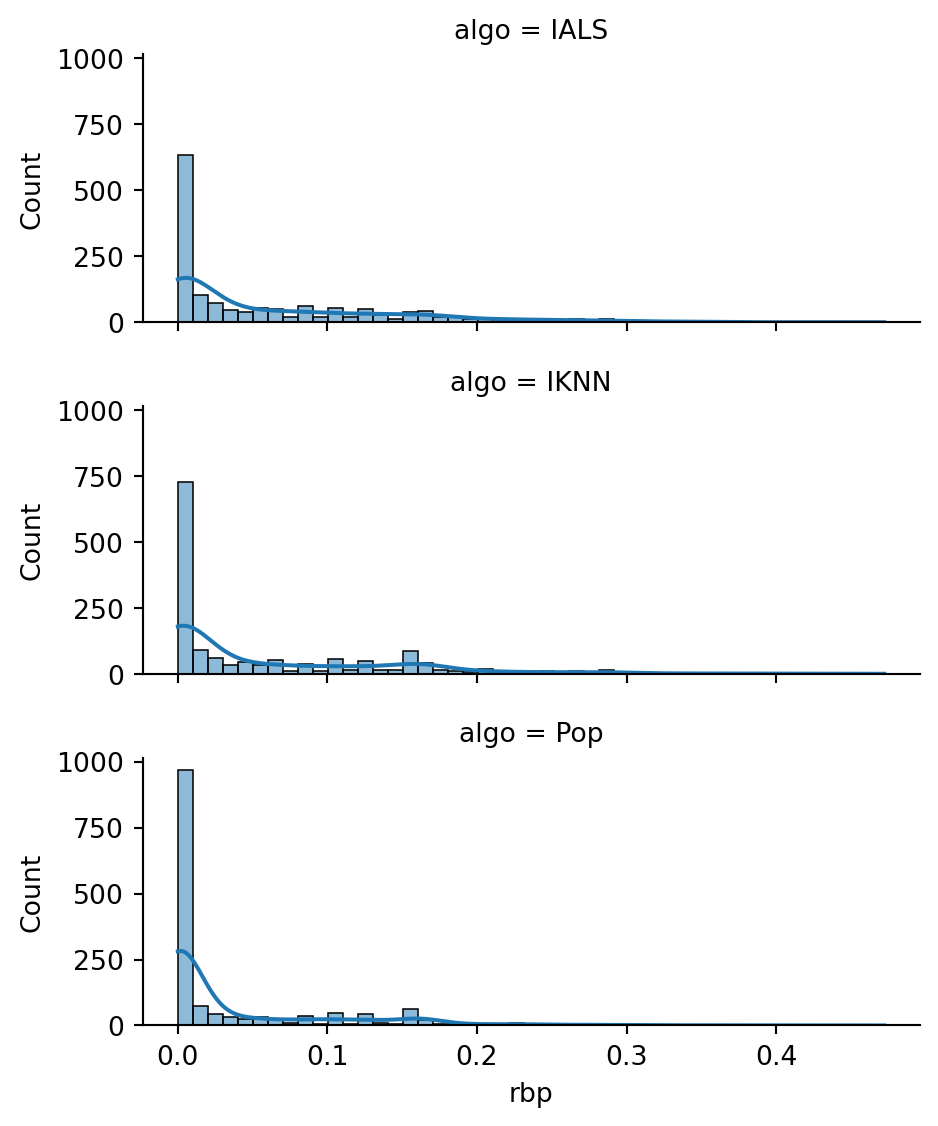

In [22]:
sns.displot(user_scores, x='rbp', row='algo', kde=True, height=2, aspect=2.5)
plt.show()

Better layout with good plotting tools. Prepare data:


In [23]:
us_lim = us_tall.loc[us_tall['metric'].isin(['RBP', 'nDCG', 'MRR'])].copy()
us_lim['metric'] = us_lim['metric'].cat.remove_unused_categories()
us_lim['metric'] = us_lim['metric'].cat.rename_categories({'MRR': 'RR'})

Compute aggregates:


In [24]:
us_agg = us_lim.groupby(['algo', 'metric'])['value'].agg(['mean', 'median'])
us_agg.columns.name = 'summary'
us_agg = us_agg.stack().to_frame('value').reset_index()

And plot:


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 4 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/user-score-dist.png
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 58'. Pick better value with 'binwidth'.


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 58'. Pick better value with 'binwidth'.


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


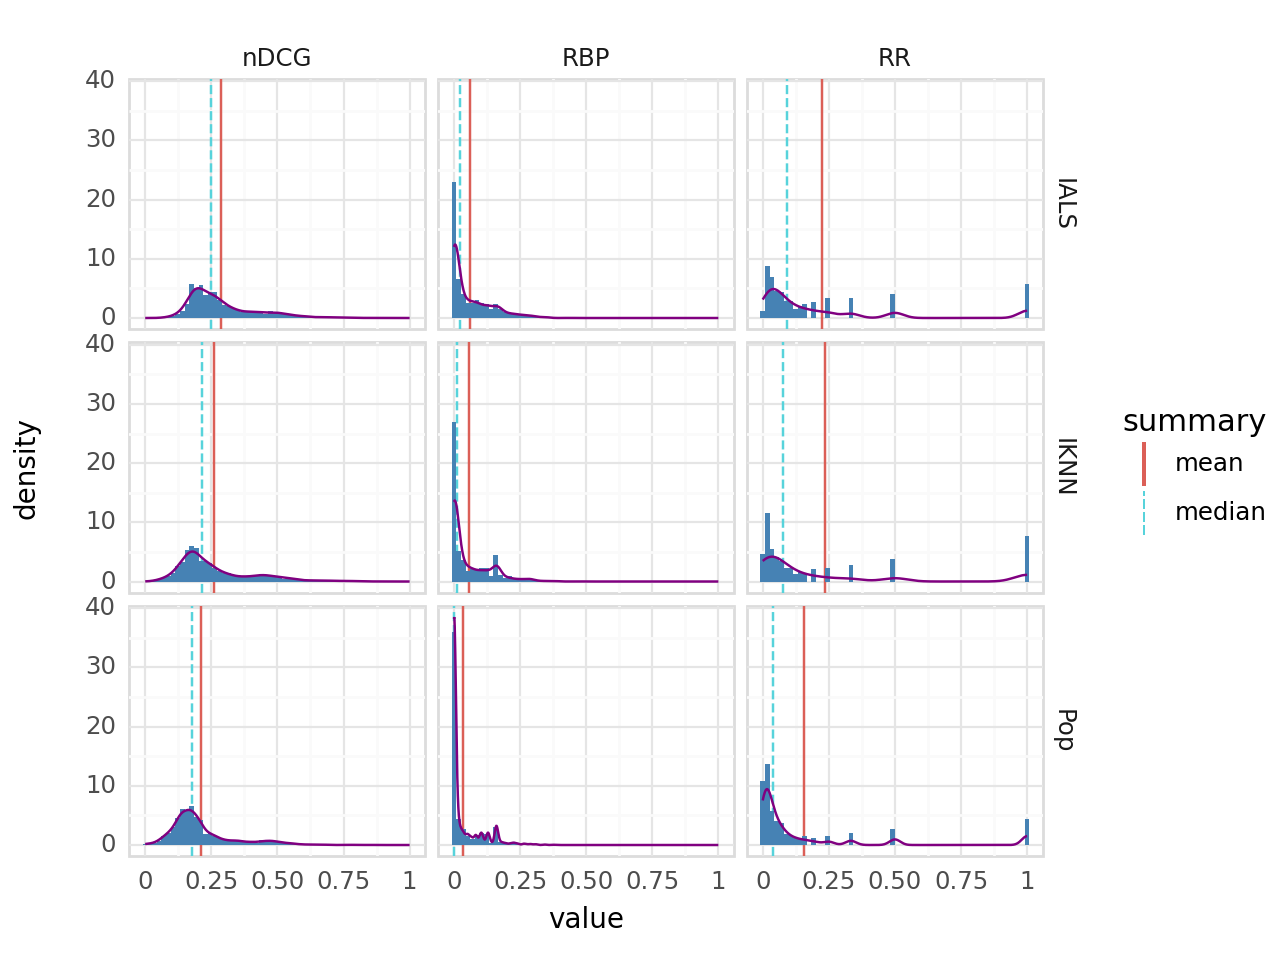

<Figure Size: (640 x 480)>

In [25]:
make_plot(
    us_lim,
    pn.aes(x='value'),
    pn.geom_vline(pn.aes(xintercept='value', linetype='summary', color='summary'), us_agg),
    pn.geom_histogram(pn.aes(y=pn.after_stat('density')), fill='steelblue'),
    pn.stat_density(color='purple'),
    pn.facet_grid('algo ~ metric'),
    width=7,
    height=4,
    file='user-score-dist.png',
)

And let's show that inline:


In [26]:
tw = EvalTable(user_scores, 'algo', 'rbp', progress=tqdm)
tw.add_stat('Mean', np.mean, ci=True)
tw.add_quantiles(['10%ile', 'Median', '90%ile'], [0.1, 0.5, 0.9], ci=True)
tw_fn = fig_dir / 'cf-example.tex'
tw_fn.write_text(tw.latex_table())
# HTML(tw.html_table())

Mean:   0%|          | 0/3 [00:00<?, ?it/s]

quantiles:   0%|          | 0/3 [00:00<?, ?it/s]

3433

## Comparison Distributions

Let's compute some comparisons!

We'll start with an nDCG pairplot.


In [27]:
wide_ndcg = user_scores['rbp'].unstack(0)
wide_rr = user_scores['recip_rank'].unstack(0)
wide_ndcg.head()

algo,IALS,IKNN,Pop
user,,,
6,2.370747e-03,0.001845,4.742844e-10
8,1.025588e-01,0.041954,3.505758e-05
10,4.789049e-07,0.002910,6.901747e-09
11,9.211196e-06,0.003603,2.684472e-02
13,3.044759e-02,0.017201,5.871357e-13


In [28]:
imp_ndcg = wide_ndcg[algos]

In [29]:
imp_ndcg.count()

algo
IALS    1500
IKNN    1500
Pop     1500
dtype: int64

In [30]:
def diff_cdf(x, y, **kwargs):
    diff = y - x
    plt.axvline(0, color='silver')
    plt.axhline(0.5, color='silver')
    sns.ecdfplot(diff, color='firebrick')

In [31]:
def diff_hist(x, y, **kwargs):
    diff = y - x
    sns.histplot(diff, color='slategrey', stat='probability')
    plt.axvline(np.median(diff), color='darkviolet')

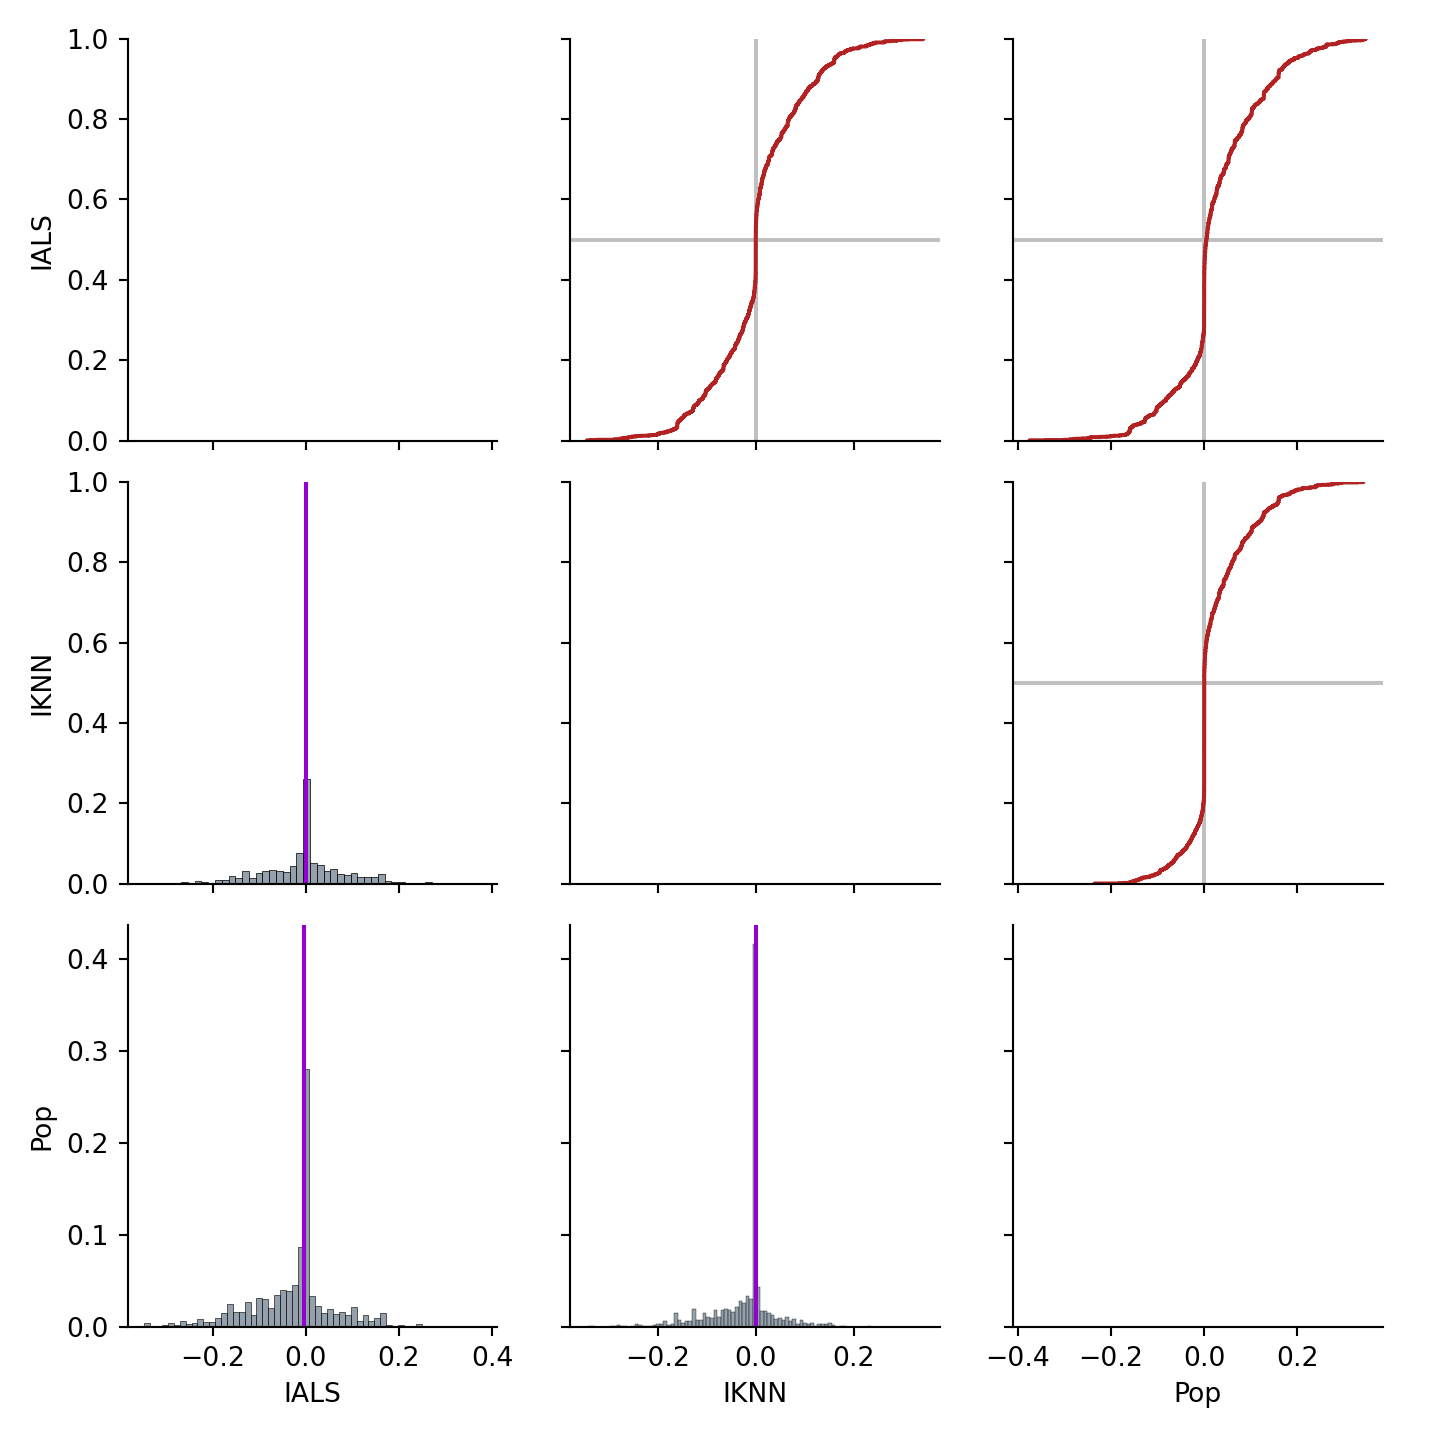

In [32]:
g = sns.PairGrid(imp_ndcg)
g.map_upper(diff_cdf)
g.map_lower(diff_hist)
plt.show()

In [33]:
pairs = [('IALS', 'IKNN'), ('IALS', 'Pop'), ('IKNN', 'Pop')]
rel_eff = pd.DataFrame({
    f'{a1} vs. {a2}': wide_ndcg[a1] - wide_ndcg[a2]
    for (a1, a2) in pairs
})
rel_eff.describe()

,IALS vs. IKNN,IALS vs. Pop,IKNN vs. Pop
count,1500.000000,1500.000000,1500.000000
mean,0.004262,0.026165,0.021903
std,0.091510,0.093700,0.066689
min,-0.344116,-0.375240,-0.235571
25%,-0.035583,-0.003006,-0.000012
50%,0.000037,0.004665,0.000064
75%,0.048779,0.070244,0.041946
max,0.341354,0.347123,0.341890


In [34]:
re_tall = rel_eff.melt(var_name='Comp', value_name='RBP')
re_tall.head()

,Comp,RBP
0,IALS vs. IKNN,0.000526
1,IALS vs. IKNN,0.060605
2,IALS vs. IKNN,-0.002910
3,IALS vs. IKNN,-0.003594
4,IALS vs. IKNN,0.013246


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 2.5 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/rbp-diff-dist.png


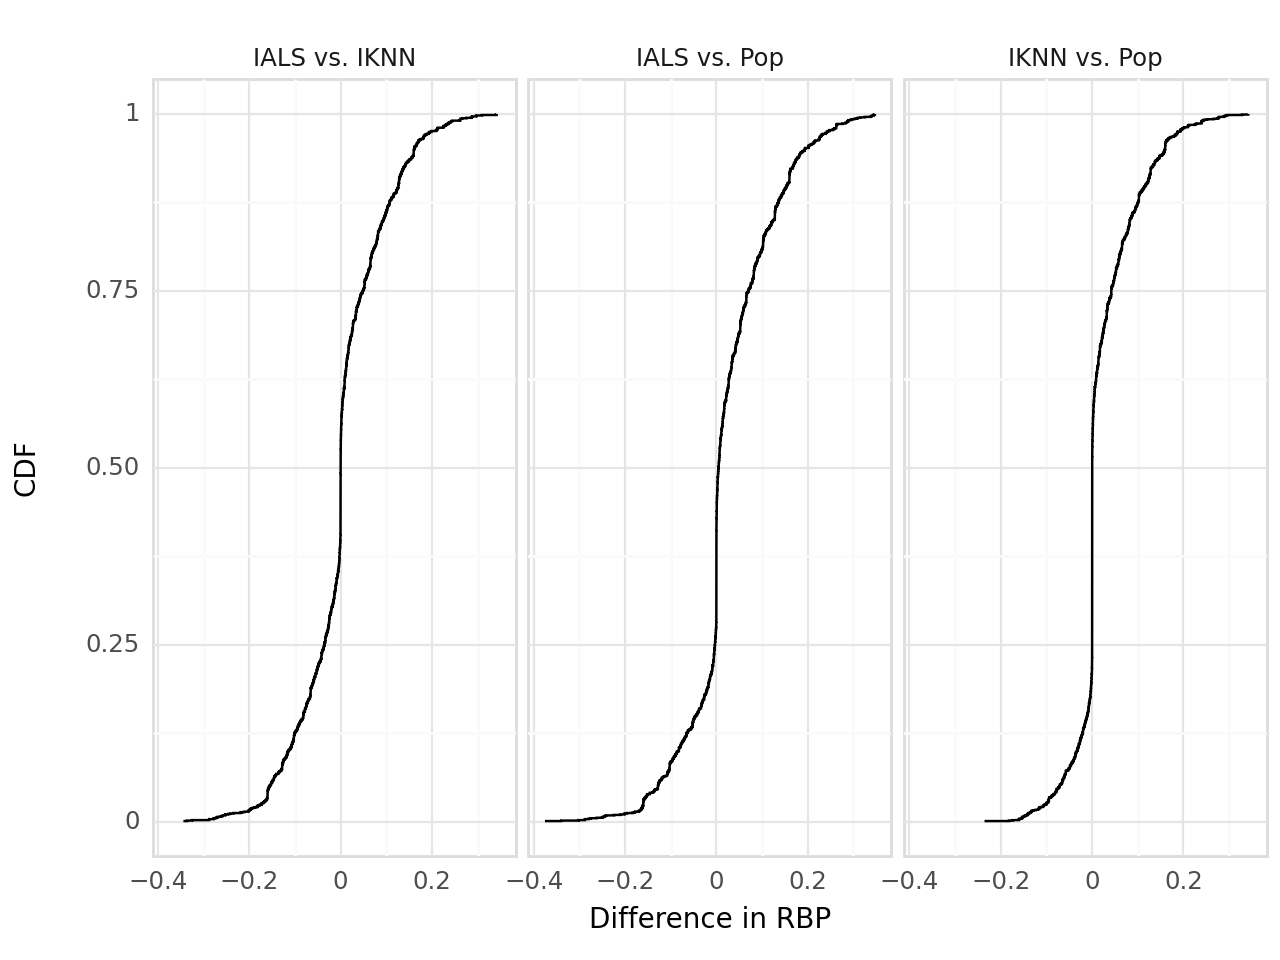

<Figure Size: (640 x 480)>

In [35]:
make_plot(
    re_tall,
    pn.aes(x='RBP'),
    pn.stat_ecdf(),
    pn.facet_grid('~ Comp'),
    pn.ylab('CDF'),
    pn.xlab('Difference in RBP'),
    width=7, height=2.5,
    file='rbp-diff-dist.png',
)

## Demographic Disaggregation

Let's look now at demographic info - what's the user distribution of demographics?


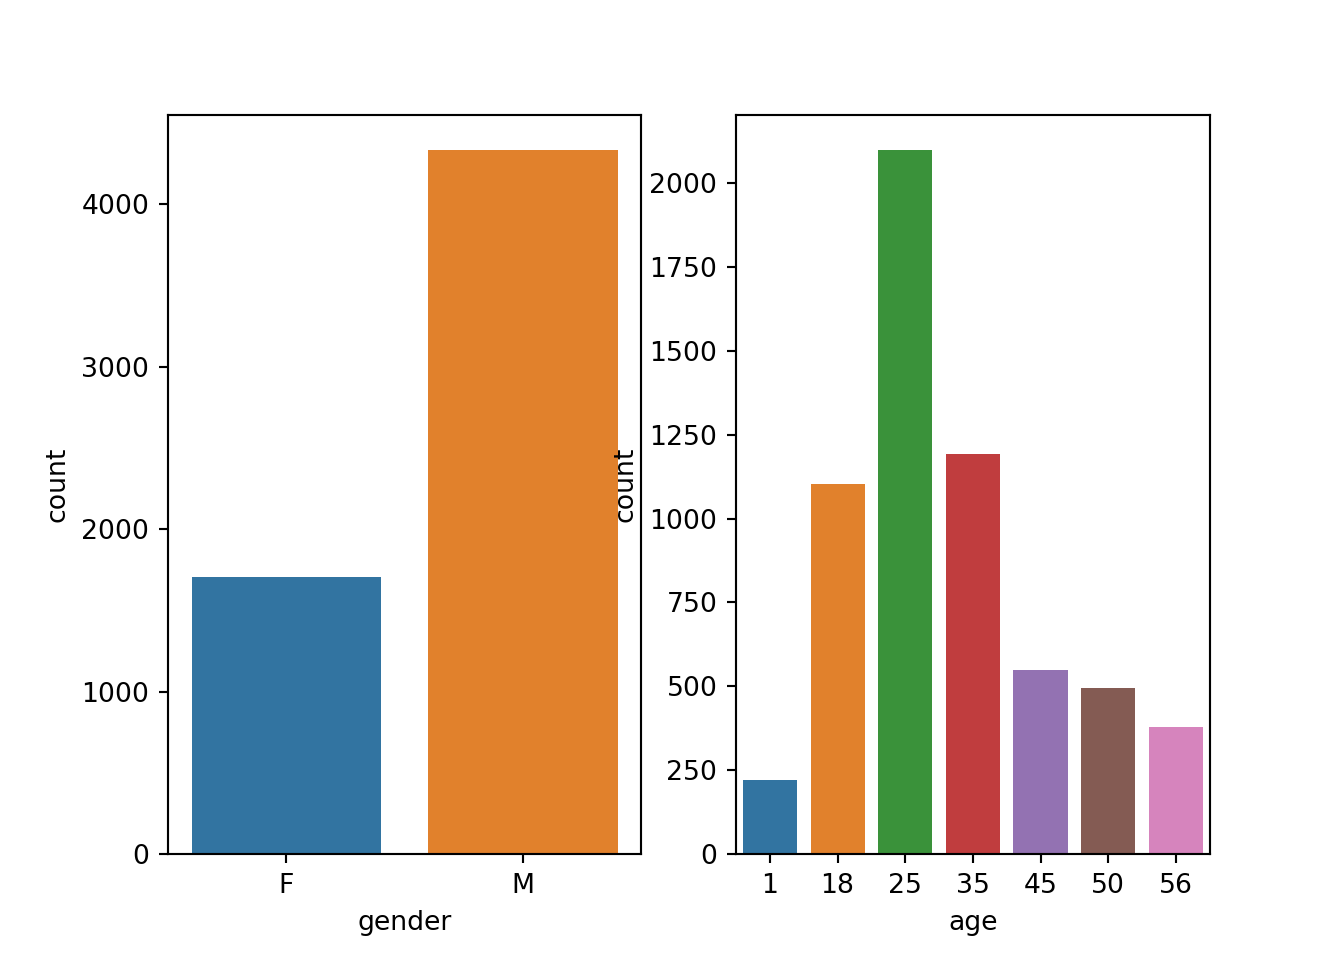

In [36]:
fig, axs = plt.subplots(1, 2)
sns.countplot(users, x='gender', ax=axs[0])
sns.countplot(users, x='age', ax=axs[1])
plt.show()

In [37]:
usdemo = user_scores.reset_index().join(users, on='user')
usdemo.head()

,algo,user,rbp,rbp05,hit,hit10,hit20,ndcg,recip_rank,gender,age,occ,zip
0,IALS,6,2.370747e-03,4.768444e-07,1.0,0.0,1.0,0.216322,0.050000,F,50,9,55117
1,IALS,8,1.025588e-01,6.250000e-02,1.0,1.0,1.0,0.351671,0.333333,M,25,12,11413
2,IALS,10,4.789049e-07,1.734723e-18,1.0,0.0,0.0,0.173779,0.017241,F,35,1,95370
3,IALS,11,9.211196e-06,1.421259e-14,1.0,0.0,0.0,0.206625,0.022222,F,25,1,04093
4,IALS,13,3.044759e-02,9.784698e-04,1.0,1.0,1.0,0.281993,0.111111,M,45,1,93304


Now, what's the RBP by gender?


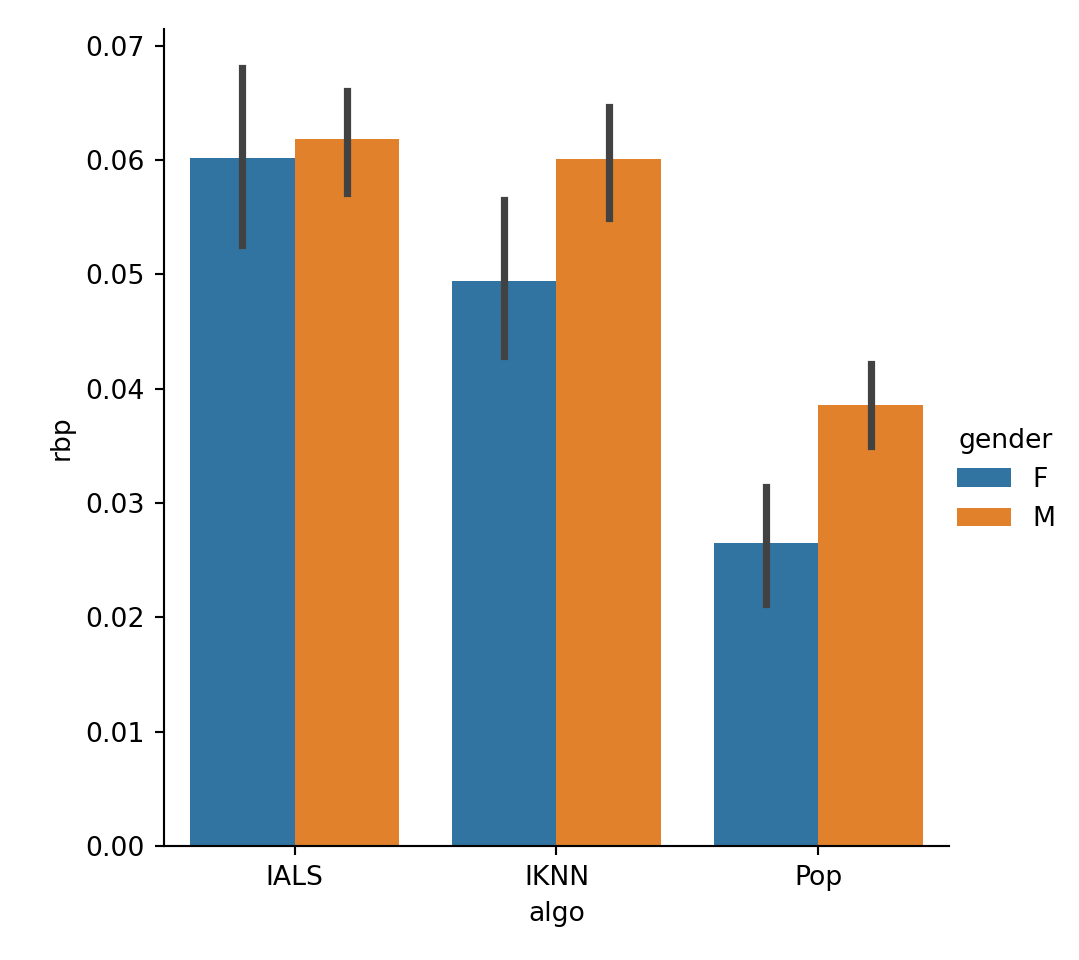

In [38]:
sns.catplot(usdemo, x='algo', y='rbp', hue='gender', kind='bar')
plt.show()

In [39]:
gender_rbp = usdemo.groupby(['algo', 'gender'])['rbp'].agg(['mean', 'sem'])
gender_rbp['ci_hi'] = gender_rbp['mean'] + 1.96 * gender_rbp['sem']
gender_rbp['ci_lo'] = gender_rbp['mean'] - 1.96 * gender_rbp['sem']
gender_rbp

mean       sem     ci_hi     ci_lo
algo gender                                        
IALS F       0.060134  0.003946  0.067868  0.052400
     M       0.061869  0.002369  0.066513  0.057225
IKNN F       0.049367  0.003454  0.056137  0.042598
     M       0.060087  0.002489  0.064965  0.055208
Pop  F       0.026527  0.002708  0.031836  0.021219
     M       0.038541  0.001970  0.042402  0.034680

[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 3 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/rbp-gender.png


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


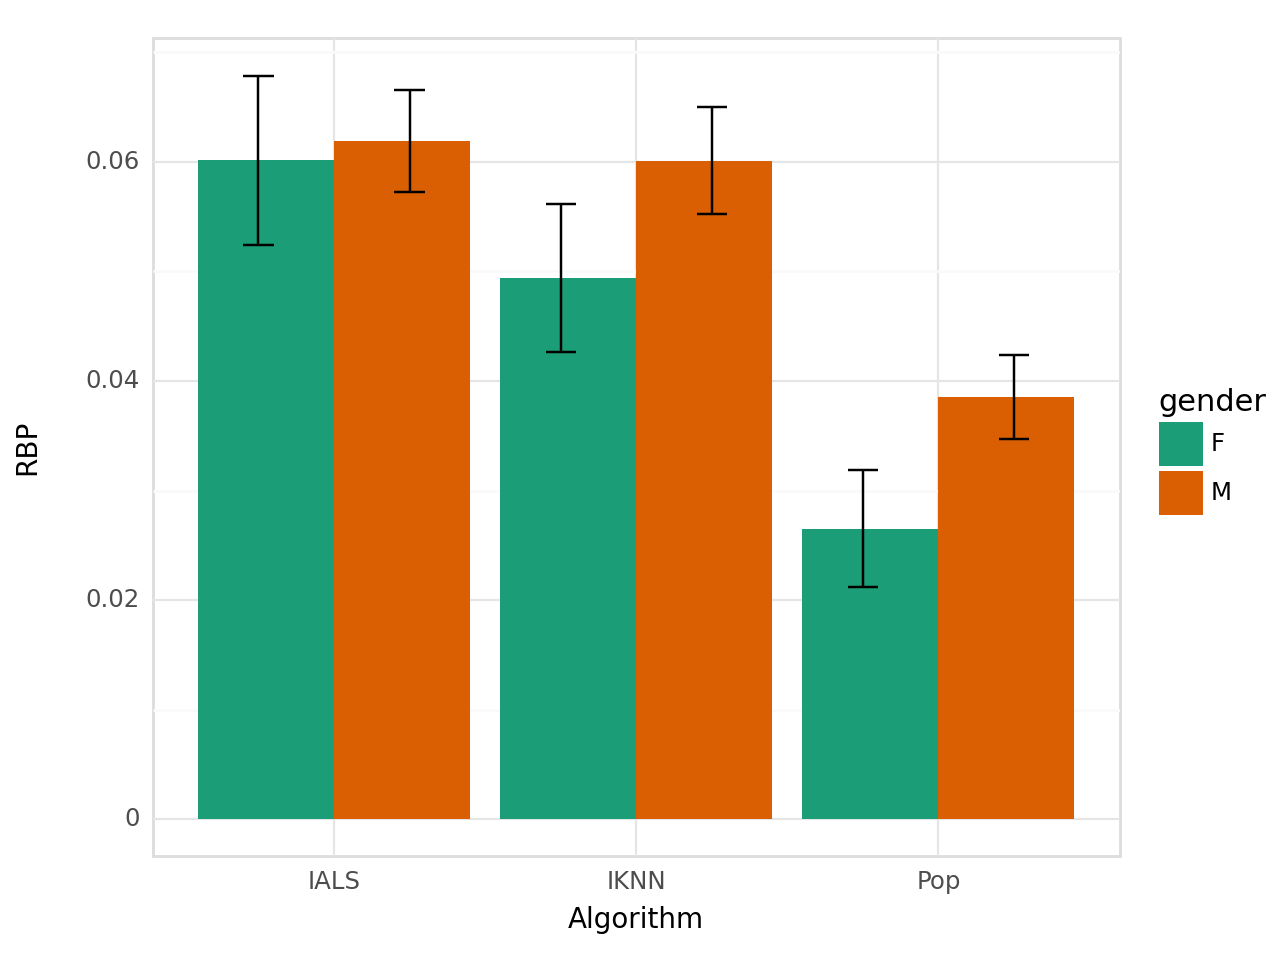

<Figure Size: (640 x 480)>

In [40]:
make_plot(
    gender_rbp.reset_index(),
    pn.aes(x='algo', y='mean', ymin='ci_lo', ymax='ci_hi', fill='gender'),
    pn.geom_bar(stat='identity', position='dodge'),
    pn.geom_errorbar(width=0.2, position=pn.position_dodge(1)),
    pn.scale_fill_brewer('qual', 'Dark2'),
    pn.ylab('RBP'),
    pn.xlab('Algorithm'),
    file='rbp-gender.png',
    width=4.5,
    height=3,
)

We can see that the best algorithm - IALS - has better gender parity than less-competitive algorithms!

T-test for IALS improving over IKNN:


In [41]:
usdemo_i = usdemo.set_index(['algo', 'gender', 'user'])
stats.ttest_rel(usdemo_i.loc[('IALS', 'F'), 'rbp'], usdemo_i.loc[('IKNN', 'F'), 'rbp'])

/tmp/ipykernel_115158/1796027223.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.


TtestResult(statistic=2.4826323509002877, pvalue=0.013437866066256155, df=413)

Let's look by age:


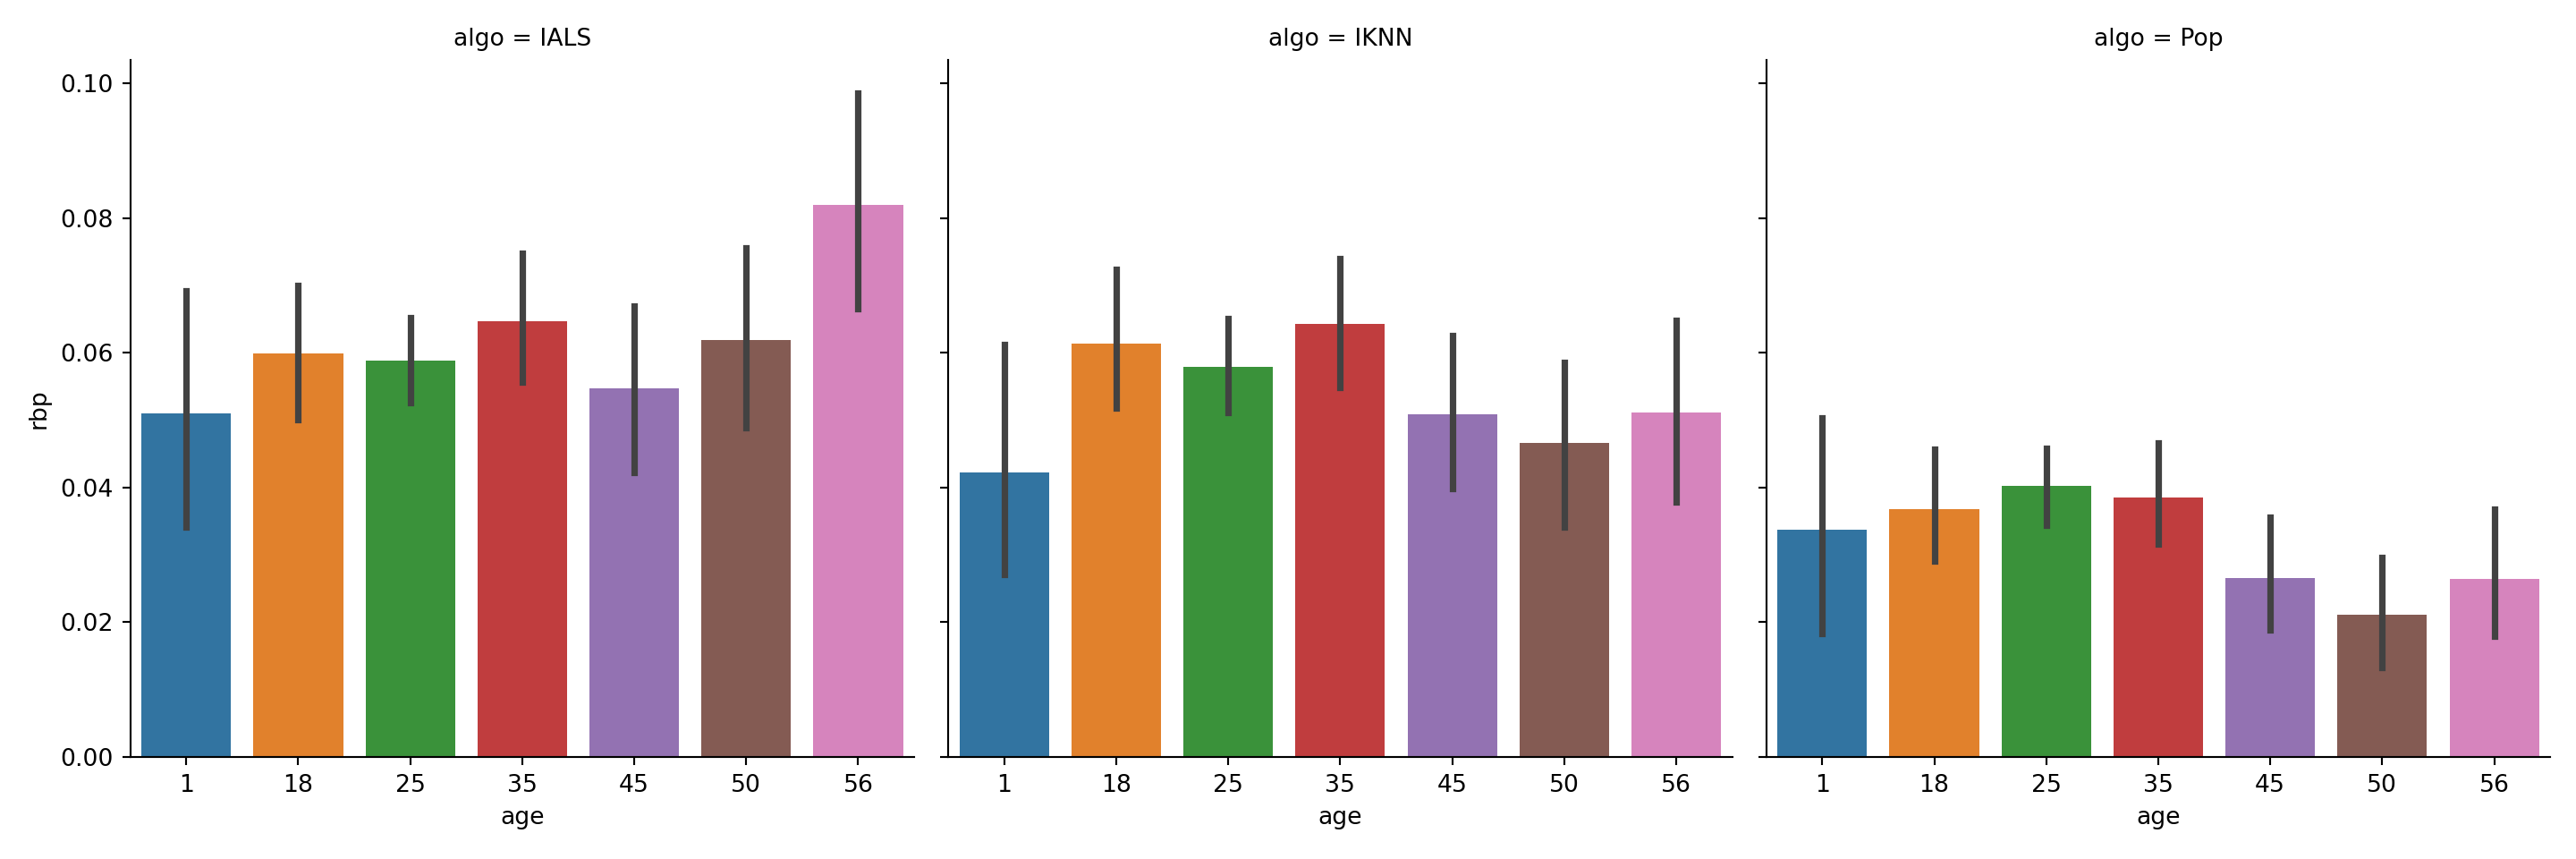

In [42]:
sns.catplot(usdemo, x='age', y='rbp', col='algo', kind='bar')
plt.show()

Now, let's compare improvements by demographic.


In [43]:
usdemo

,algo,user,rbp,rbp05,hit,hit10,hit20,ndcg,recip_rank,gender,age,occ,zip
0,IALS,6,2.370747e-03,4.768444e-07,1.0,0.0,1.0,0.216322,0.050000,F,50,9,55117
1,IALS,8,1.025588e-01,6.250000e-02,1.0,1.0,1.0,0.351671,0.333333,M,25,12,11413
2,IALS,10,4.789049e-07,1.734723e-18,1.0,0.0,0.0,0.173779,0.017241,F,35,1,95370
3,IALS,11,9.211196e-06,1.421259e-14,1.0,0.0,0.0,0.206625,0.022222,F,25,1,04093
4,IALS,13,3.044759e-02,9.784698e-04,1.0,1.0,1.0,0.281993,0.111111,M,45,1,93304
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,Pop,6016,1.024009e-01,6.250000e-02,1.0,1.0,1.0,0.311298,0.333333,M,45,1,37209
4496,Pop,6019,2.887446e-06,4.440896e-16,1.0,0.0,0.0,0.143533,0.020000,M,25,0,10024
4497,Pop,6032,3.831239e-07,8.673617e-19,1.0,0.0,0.0,0.135166,0.016949,M,45,7,55108
4498,Pop,6034,4.146011e-52,1.820884e-158,1.0,0.0,0.0,0.080711,0.001912,M,25,14,94117


In [44]:
wide_demo = usdemo.pivot(index='user', columns='algo', values='rbp').join(users)
wide_demo

,IALS,IKNN,Pop,gender,age,occ,zip
user,,,,,,,
6,2.370747e-03,0.001845,4.742844e-10,F,50,9,55117
8,1.025588e-01,0.041954,3.505758e-05,M,25,12,11413
10,4.789049e-07,0.002910,6.901747e-09,F,35,1,95370
11,9.211196e-06,0.003603,2.684472e-02,F,25,1,04093
13,3.044759e-02,0.017201,5.871357e-13,M,45,1,93304
...,...,...,...,...,...,...,...
6016,6.490371e-05,0.065536,1.024009e-01,M,45,1,37209
6019,1.157921e-09,0.042191,2.887446e-06,M,25,0,10024
6032,1.239268e-01,0.001845,3.831239e-07,M,45,7,55108


In [45]:
wide_demo['IKNN-Pop'] = wide_demo['IKNN'] - wide_demo['Pop']
wide_demo['IALS-Pop'] = wide_demo['IALS'] - wide_demo['Pop']
wide_demo['IALS-IKNN'] = wide_demo['IALS'] - wide_demo['IKNN']

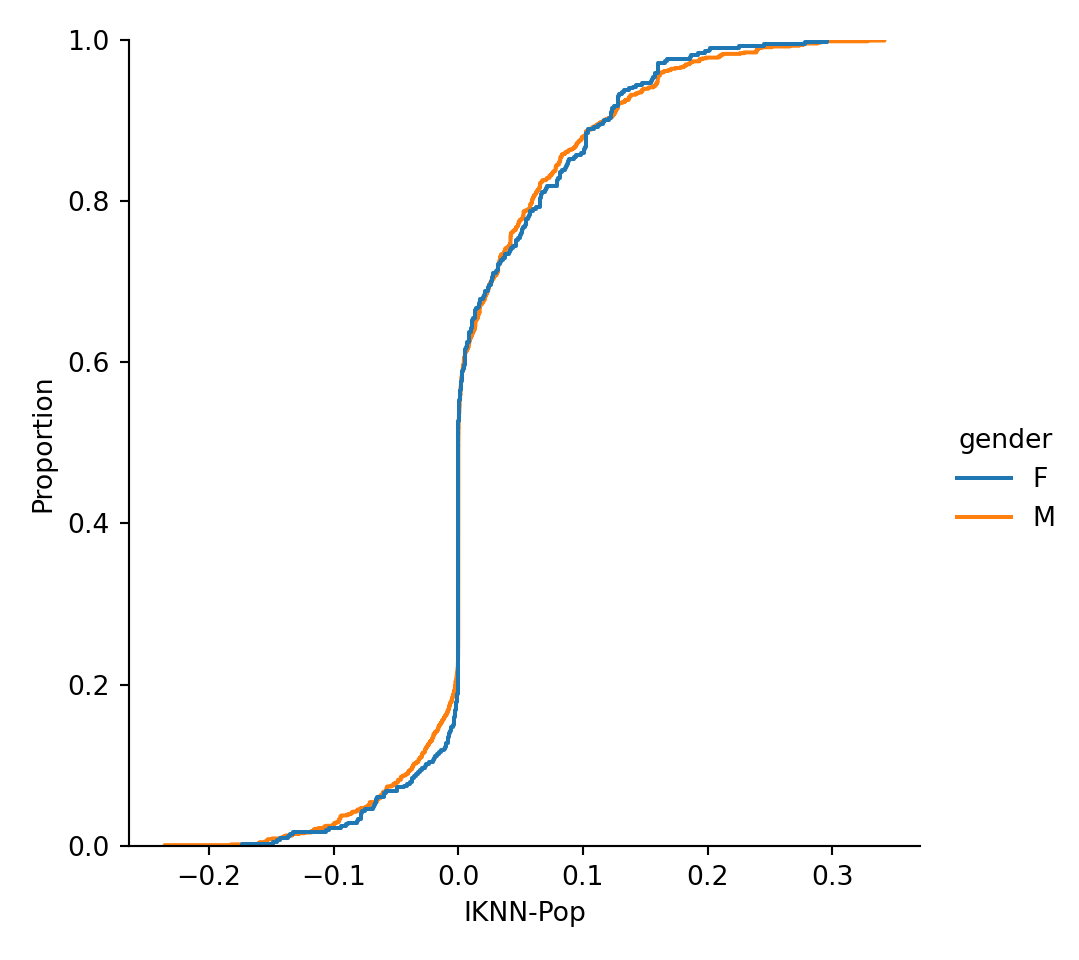

In [46]:
sns.displot(wide_demo, x='IKNN-Pop', hue='gender', kind='ecdf')
plt.show()

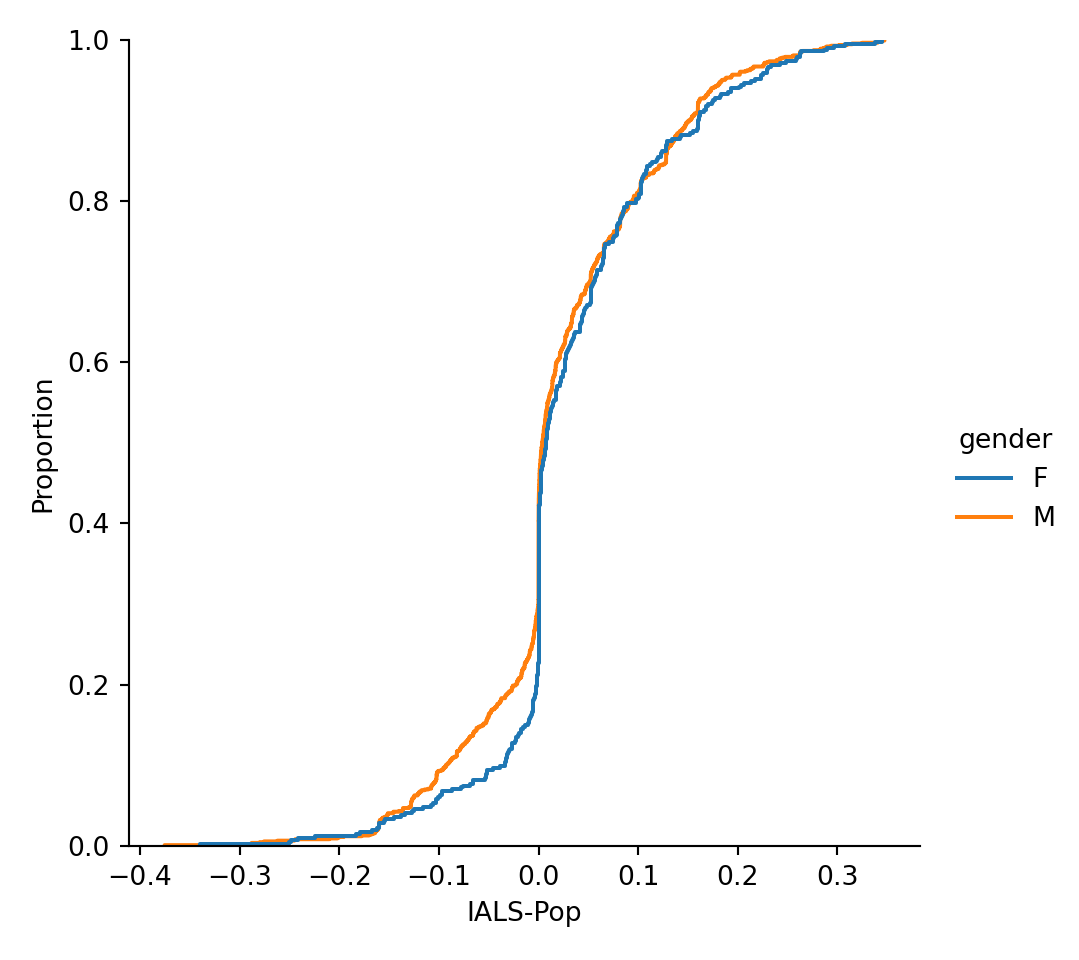

In [47]:
sns.displot(wide_demo, x='IALS-Pop', hue='gender', kind='ecdf')
plt.show()

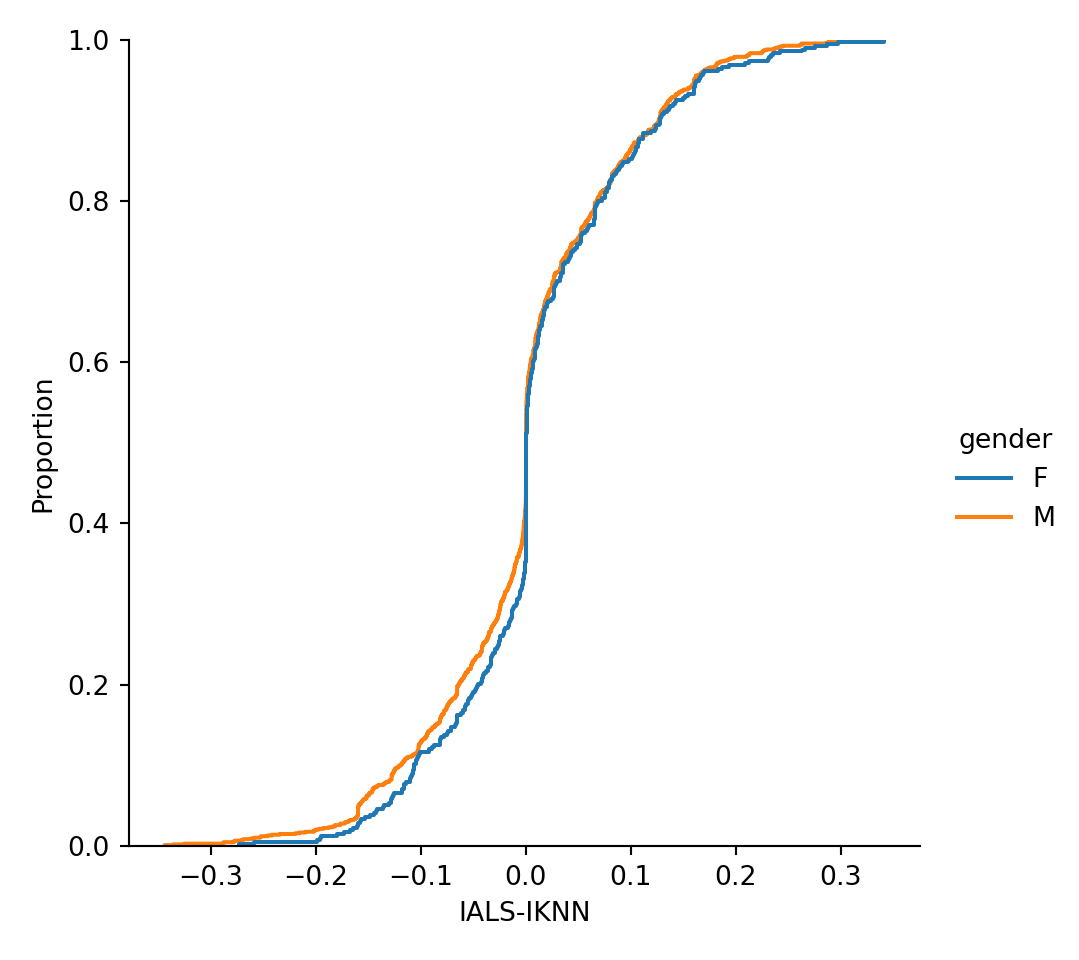

In [48]:
sns.displot(wide_demo, x='IALS-IKNN', hue='gender', kind='ecdf')
plt.show()

[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 3 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/rbp-gender-improve-cdf.png


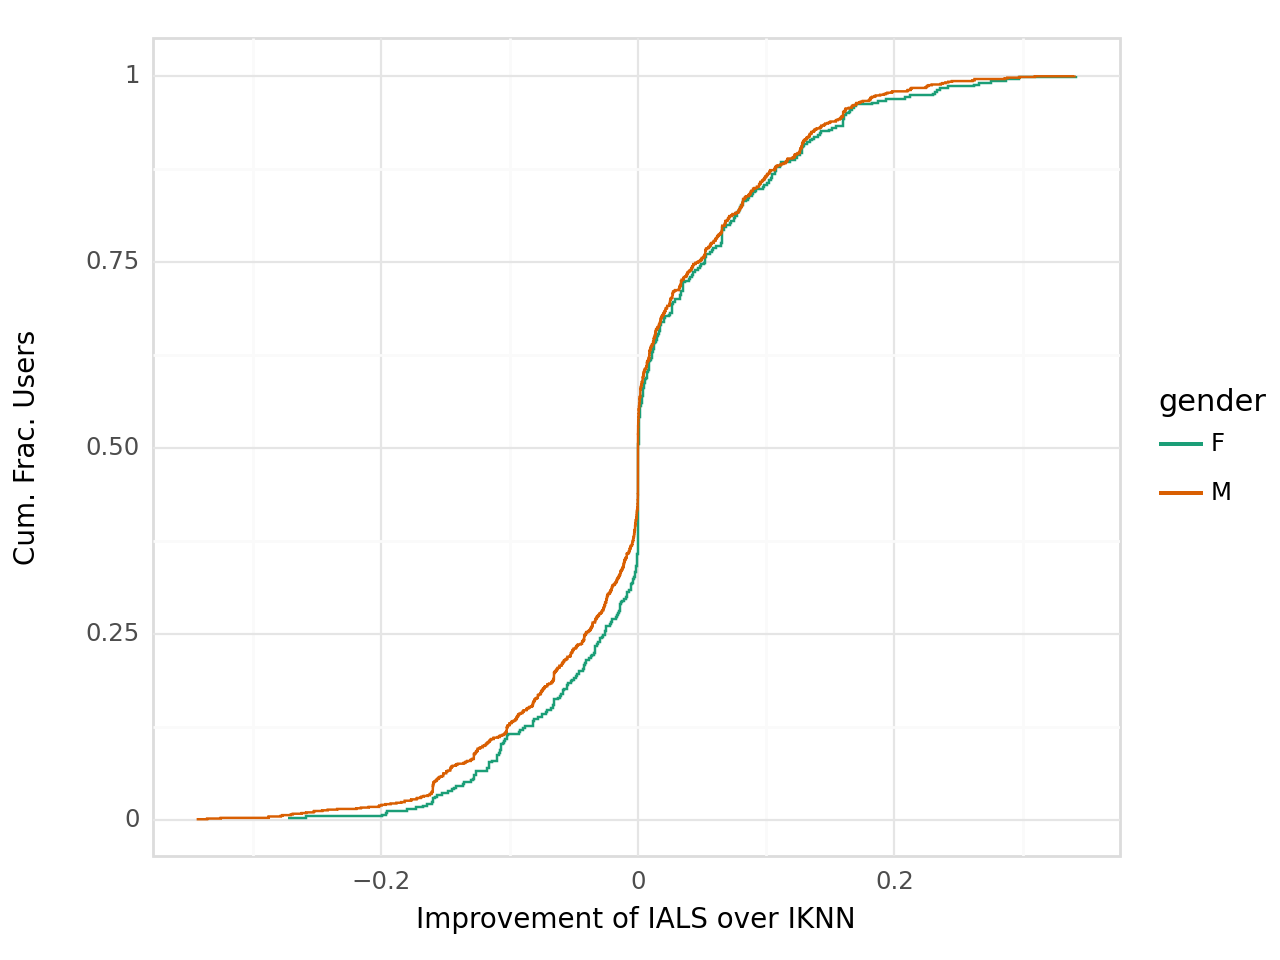

<Figure Size: (640 x 480)>

In [49]:
make_plot(
    wide_demo,
    pn.aes(x='IALS-IKNN', color='gender'),
    pn.stat_ecdf(),
    pn.scale_color_brewer('qual', 'Dark2'),
    pn.xlab('Improvement of IALS over IKNN'),
    pn.ylab('Cum. Frac. Users'),
    file='rbp-gender-improve-cdf.png',
    width=4.5,
    height=3,
)

Because the blue curves are (slightly) to the right of the orange curves, we can see that the improvement is slightly *better*, on average, for female uses than for male users!  Let's look at a box plot for slightly easier comparison.


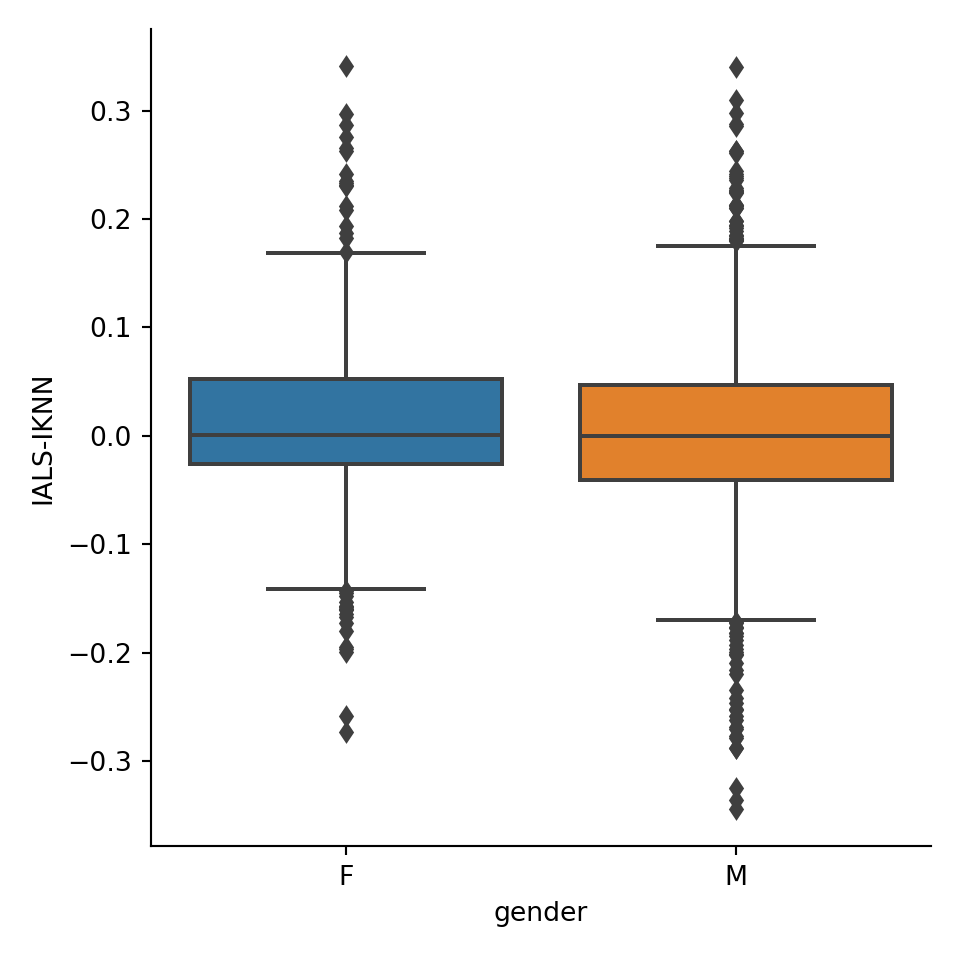

In [50]:
sns.catplot(wide_demo, x='gender', y='IALS-IKNN', kind='box')
plt.show()

Now, when we combine this difference analysis with the overall performance analysis, we can see that conclude that the IALS algorithm *closes the gap* in performance w.r.t. the III algorithm, but does not eliminate it.

## Uncertain Browsing Models

We see above that changing the browsing model actually changes the ordering of the two top systems.

Let's look at how RBP changes with browsing model parameter.  We're going to need to decompose the RBP metric (fortunately it's amenable to that).

Start by combining runs with relevance:


In [51]:
jr = pd.merge(recs, test[['user', 'item', 'rating']], on=['user', 'item'], how='left')
jr['good'] = jr['rating'].notnull()
jr

,algo,item,score,user,rank,rating,good
0,IKNN,1265,9.752318,6,1,NaN,False
1,IKNN,1196,9.746611,6,2,NaN,False
2,IKNN,1270,9.562931,6,3,NaN,False
3,IKNN,356,9.534776,6,4,NaN,False
4,IKNN,919,9.496835,6,5,NaN,False
...,...,...,...,...,...,...,...
4499995,IALS,2590,0.718621,6036,996,NaN,False
4499996,IALS,2014,0.718583,6036,997,NaN,False
4499997,IALS,583,0.718314,6036,998,NaN,False
4499998,IALS,77,0.718271,6036,999,NaN,False


For computation, we only need the *good* items, since non-relevant items don't contribute to RBP.  Grab the user lists so we have them:


In [52]:
rlists = jr[['algo', 'user']].drop_duplicates(ignore_index=True)
rlists

,algo,user
0,IKNN,6
1,IKNN,8
2,IKNN,10
3,IKNN,11
4,IKNN,13
...,...,...
4495,IALS,6016
4496,IALS,6019
4497,IALS,6032
4498,IALS,6034


Now get the good items:


In [53]:
rgood = jr[jr['good']]
rgood

,algo,item,score,user,rank,rating,good
20,IKNN,2406,9.107272,6,21,5.0,True
80,IKNN,1101,8.163657,6,81,4.0,True
112,IKNN,1569,7.825029,6,113,4.0,True
304,IKNN,3699,6.720015,6,305,4.0,True
1006,IKNN,377,10.832268,8,7,4.0,True
...,...,...,...,...,...,...,...
4499097,IALS,357,1.030969,6036,98,3.0,True
4499134,IALS,150,1.009053,6036,135,4.0,True
4499174,IALS,592,0.986259,6036,175,3.0,True
4499284,IALS,1354,0.945874,6036,285,4.0,True


In [54]:
rg_ranks = xa.DataArray(rgood['rank'].astype('f4'), dims=['eevt'], name='rank')
rg_ranks

<xarray.DataArray 'rank' (eevt: 19783)>
array([ 21.,  81., 113., ..., 175., 285., 424.], dtype=float32)
Coordinates:
  * eevt     (eevt) int64 20 80 112 304 1006 ... 4499134 4499174 4499284 4499423

We're going to start by looking at how RBP changes with the parameter value. Let's get some points, evenly spaced, with specified resolution and no endpoints:


In [55]:
p_res = 0.01
bm_pts = np.linspace(0, 1, int(1 / p_res) + 1)[1:-1]
bm_pts = xa.DataArray(bm_pts, coords={'patience': bm_pts})
bm_pts

<xarray.DataArray (patience: 99)>
array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])
Coordinates:
  * patience  (patience) float64 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98 0.99

Now we can compute the log of the RBP contribution of each item, for each point value:


In [56]:
log_eerbp = np.log(bm_pts) * rg_ranks
log_eerbp

<xarray.DataArray (patience: 99, eevt: 19783)>
array([[-9.67085739e+01, -3.73018785e+02, -5.20384231e+02, ...,
        -8.05904783e+02, -1.31247350e+03, -1.95259216e+03],
       [-8.21524831e+01, -3.16873863e+02, -4.42058600e+02, ...,
        -6.84604026e+02, -1.11492656e+03, -1.65869775e+03],
       [-7.36377158e+01, -2.84031190e+02, -3.96241042e+02, ...,
        -6.13647632e+02, -9.99369001e+02, -1.48678055e+03],
       ...,
       [-6.39643357e-01, -2.46719581e+00, -3.44189045e+00, ...,
        -5.33036131e+00, -8.68087413e+00, -1.29147040e+01],
       [-4.24256854e-01, -1.63641929e+00, -2.28290593e+00, ...,
        -3.53547378e+00, -5.75777159e+00, -8.56594790e+00],
       [-2.11057053e-01, -8.14077204e-01, -1.13568795e+00, ...,
        -1.75880877e+00, -2.86434572e+00, -4.26134240e+00]])
Coordinates:
  * patience  (patience) float64 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98 0.99
  * eevt      (eevt) int64 20 80 112 304 ... 4499134 4499174 4499284 4499423

Now, we want to compute the RBPs for each algorithm. The easy way to do this will be to group by the algorithm, sum (after exponentiating), and divide by the number of users.

- RBP for a user is the sum of individual doc RBPs
- RBP for a user with no relevant docs is 0
- RBP for the system is the mean of the per-user RBPs

Let's go!  Put this in an appropriately-alligned xarray:


In [57]:
algo_xa = xa.DataArray(rgood['algo'], dims=['eevt'])
algo_xa

<xarray.DataArray 'algo' (eevt: 19783)>
array(['IKNN', 'IKNN', 'IKNN', ..., 'IALS', 'IALS', 'IALS'], dtype=object)
Coordinates:
  * eevt     (eevt) int64 20 80 112 304 1006 ... 4499134 4499174 4499284 4499423

In [58]:
def _log_rbp(x):
    dim = x.dims[0]
    # sum the contributions
    lsum = sps.logsumexp(x, axis=1)
    sxa = xa.DataArray(lsum, coords={dim: x.coords[dim]})
    # multiply by (1 - patience)
    sxa += np.log(1 - bm_pts)
    return sxa
log_rbp = log_eerbp.groupby(algo_xa).map(_log_rbp)
# divide by number of users
log_rbp -= np.log(n_users)
log_rbp

<xarray.DataArray (patience: 99, algo: 3)>
array([[-6.89635974, -6.60899784, -7.18528116],
       [-6.20507725, -5.91970477, -6.49526122],
       [-5.80149165, -5.51813551, -6.0929623 ],
       [-5.51570371, -5.23439194, -5.80848612],
       [-5.29446876, -5.01523048, -5.588589  ],
       [-5.11407015, -4.83693557, -5.40955525],
       [-4.96185664, -4.68685709, -5.25873463],
       [-4.83027654, -4.55744447, -5.1285765 ],
       [-4.71445887, -4.44382786, -5.01421088],
       [-4.61107774, -4.34268251, -4.91231294],
       [-4.51776094, -4.25163739, -4.82051154],
       [-4.43275694, -4.16894213, -4.73705624],
       [-4.35473563, -4.09326782, -4.66061803],
       [-4.28266312, -4.0235818 , -4.59016416],
       [-4.21571986, -3.95906573, -4.52487621],
       [-4.15324519, -3.89906023, -4.46409471],
       [-4.09469879, -3.84302625, -4.40728051],
       [-4.03963313, -3.79051755, -4.35398729],
       [-3.98767338, -3.74116064, -4.30384146],
       [-3.9385025 , -3.69463982, -4.25652722],
...
       [-2.79050731, -2.86245923, -3.34598784],
       [-2.78960884, -2.87117507, -3.35138113],
       [-2.78979062, -2.88124324, -3.3578974 ],
       [-2.79117219, -2.89280707, -3.36565708],
       [-2.79389717, -2.90603895, -3.37480703],
       [-2.79813991, -2.92114803, -3.38552777],
       [-2.80411467, -2.93839078, -3.39804322],
       [-2.81208864, -2.95808533, -3.41263392],
       [-2.82240046, -2.98063183, -3.42965559],
       [-2.83548783, -3.0065417 , -3.44956585],
       [-2.85192943, -3.0364813 , -3.47296361],
       [-2.87251126, -3.07133919, -3.50064968],
       [-2.89833583, -3.11233456, -3.53372338],
       [-2.93101166, -3.16120069, -3.57374432],
       [-2.9730033 , -3.22051562, -3.62301914],
       [-3.02833207, -3.29434679, -3.68514957],
       [-3.10413741, -3.38964604, -3.76619586],
       [-3.21472094, -3.51975331, -3.87755928],
       [-3.39477199, -3.71550299, -4.04508354],
       [-3.76621374, -4.07975376, -4.35439394]])
Coordinates:
  * patience  (patience) float64 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98 0.99
  * algo      (algo) object 'IALS' 'IKNN' 'Pop'

This array is now set up with what we need. Let's turn it into a data frame, and we can start plotting.


In [59]:
patience_rbp = np.exp(log_rbp).to_pandas().stack().reset_index(name='RBP')
patience_rbp

,patience,algo,RBP
0,0.01,IALS,0.001011
1,0.01,IKNN,0.001348
2,0.01,Pop,0.000758
3,0.02,IALS,0.002019
4,0.02,IKNN,0.002686
...,...,...,...
292,0.98,IKNN,0.024343
293,0.98,Pop,0.017508
294,0.99,IALS,0.023140
295,0.99,IKNN,0.016912


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 4 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/rbp-uncertain-response.png


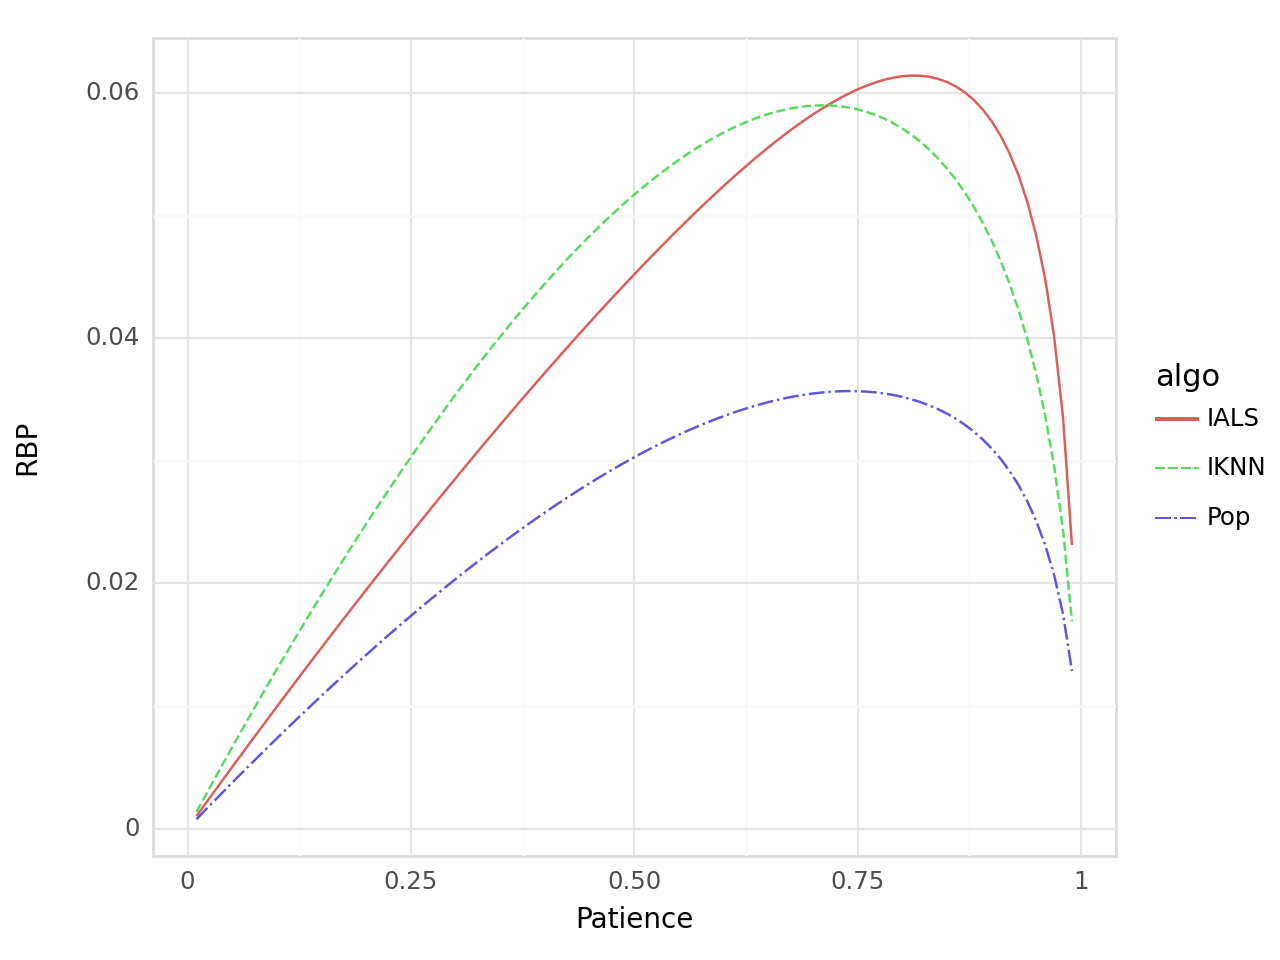

<Figure Size: (640 x 480)>

In [60]:
make_plot(
    patience_rbp,
    pn.aes(x='patience', y='RBP', color='algo', linetype='algo'),
    pn.geom_line(),
    pn.xlab('Patience'),
    file='rbp-uncertain-response.png',
    width=4.5,
    height=4,
)

This shows us how performacne changes as the unknown parameter changes. For lower patience parameters (higher weight at the top of the list), III is outperforming, but for higher parameters IALS starts to win. This suggests that III is doing a better job of putting *something* relevant high in the list (consistent with its good performance on MRR), but IALS is better at putting *multiple* items at reasonable places in the list (consistent with its better performance on nDCG).

### Probabilistic Uncertainty

Not all patience values are equally likely, however. We can take a Bayesian approach and encode our beliefs or current knowledge over the different parameter values as a probability distribution, and use that to derive a distribution of RBP values.

So let's derive a Beta distribution whose mode is our original parameter value (0.8), but has some diffusion:


In [61]:
tgt_mode = 0.8
alpha = 5
beta = (1 - tgt_mode) * alpha + (2 * tgt_mode - 1)
beta /= tgt_mode

In [62]:
bm_dist = stats.beta(alpha, beta)
bm_dist.mean()

0.7142857142857143

In [63]:
alpha, beta

(5, 1.9999999999999998)

/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 2 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/rbp-uncertain-prior.png


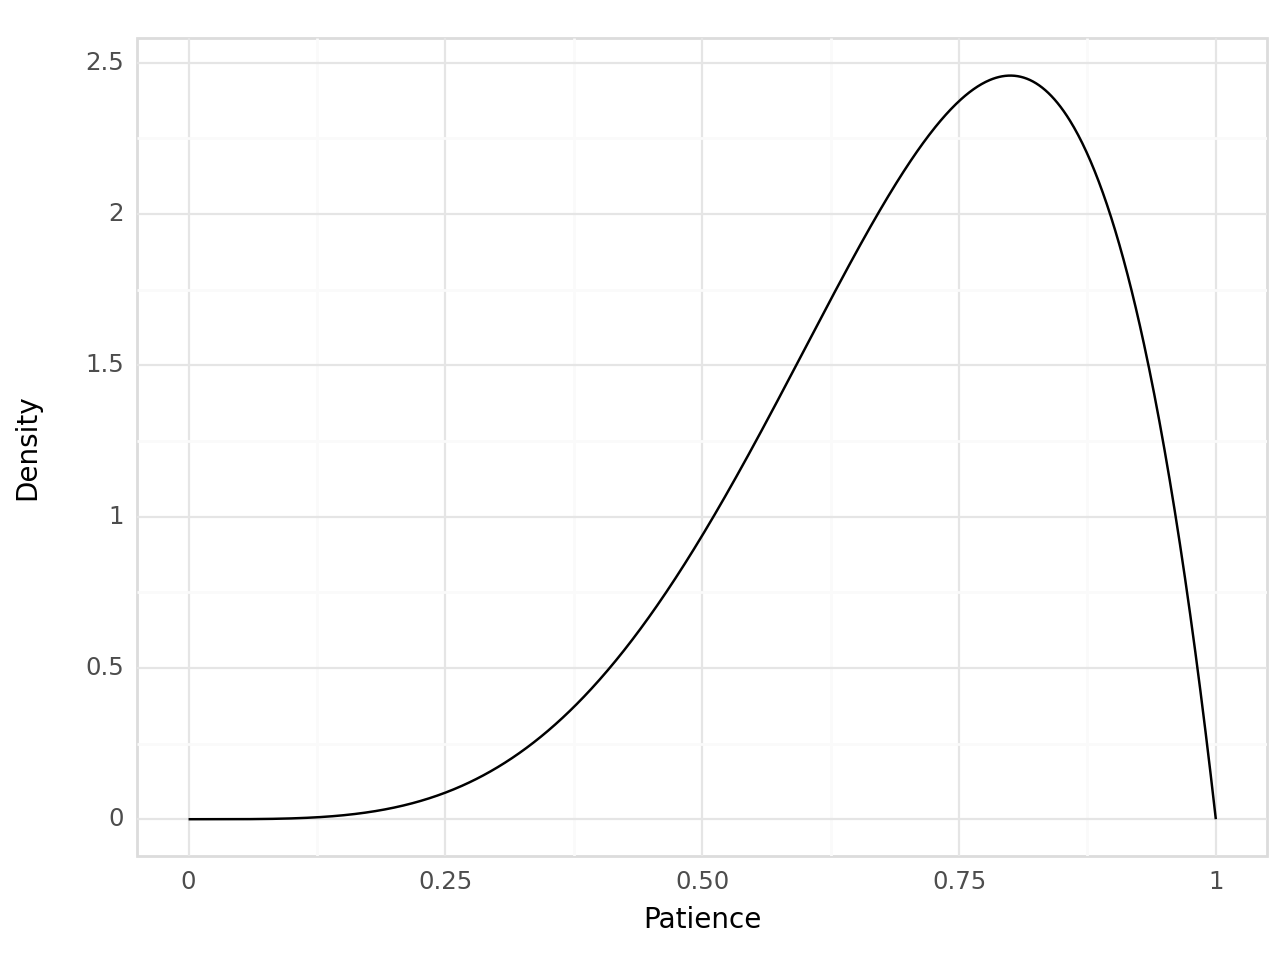

<Figure Size: (640 x 480)>

In [64]:
xs = np.linspace(0, 1, 1001)
ys = bm_dist.pdf(xs)
make_plot(
    pd.DataFrame({'Patience': xs, 'Density': ys}),
    pn.aes(x='Patience', y='Density'),
    pn.geom_line(),
    file='rbp-uncertain-prior.png',
    width=4.5,
    height=2,
)

Now, to compute the patience probabilities, we need to weight each value. We can do this by multipling the PDF by the resolution at that point.


In [65]:
patience_rbp['weight'] = bm_dist.pdf(patience_rbp['patience']) * p_res
patience_rbp

,patience,algo,RBP,weight
0,0.01,IALS,0.001011,2.970000e-09
1,0.01,IKNN,0.001348,2.970000e-09
2,0.01,Pop,0.000758,2.970000e-09
3,0.02,IALS,0.002019,4.704000e-08
4,0.02,IKNN,0.002686,4.704000e-08
...,...,...,...,...
292,0.98,IKNN,0.024343,5.534209e-03
293,0.98,Pop,0.017508,5.534209e-03
294,0.99,IALS,0.023140,2.881788e-03
295,0.99,IKNN,0.016912,2.881788e-03


We can now use these to compute cumulative distributions.


In [66]:
prbp_cdf = patience_rbp.groupby('algo').apply(lambda df: df.sort_values('RBP')['weight'].cumsum())
prbp_cdf.reset_index('algo', inplace=True, drop=True)
patience_rbp['cdf'] = prbp_cdf
patience_rbp

,patience,algo,RBP,weight,cdf
0,0.01,IALS,0.001011,2.970000e-09,2.970000e-09
1,0.01,IKNN,0.001348,2.970000e-09,2.970000e-09
2,0.01,Pop,0.000758,2.970000e-09,2.970000e-09
3,0.02,IALS,0.002019,4.704000e-08,5.001000e-08
4,0.02,IKNN,0.002686,4.704000e-08,5.001000e-08
...,...,...,...,...,...
292,0.98,IKNN,0.024343,5.534209e-03,9.829996e-03
293,0.98,Pop,0.017508,5.534209e-03,1.350486e-02
294,0.99,IALS,0.023140,2.881788e-03,6.335299e-03
295,0.99,IKNN,0.016912,2.881788e-03,3.119541e-03


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 2 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/rbp-uncertain-post.png


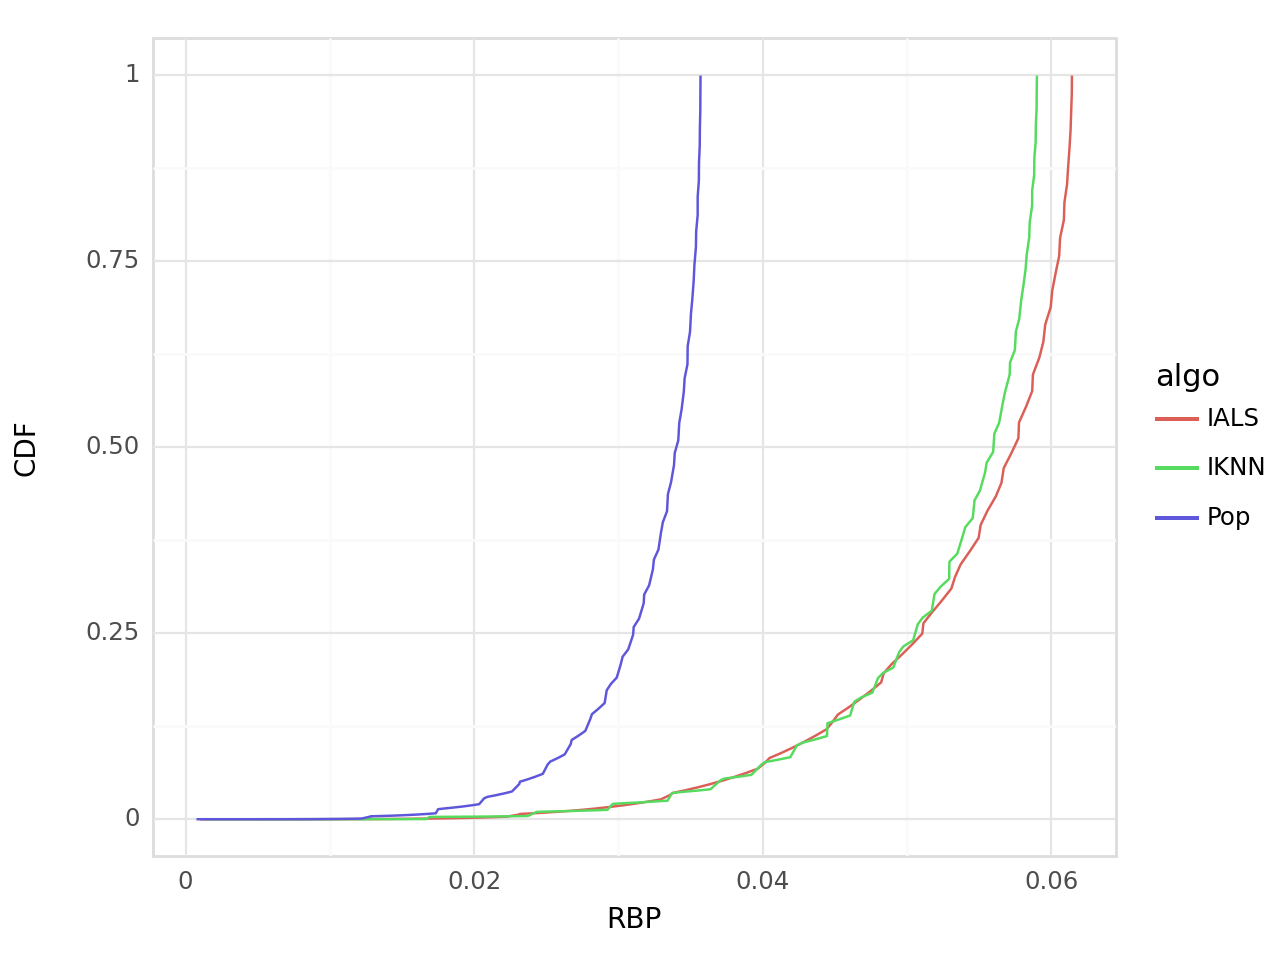

<Figure Size: (640 x 480)>

In [67]:
make_plot(
    patience_rbp,
    pn.aes(x='RBP', y='cdf', color='algo'),
    pn.geom_line(),
    pn.ylab('CDF'),
    file='rbp-uncertain-post.png',
    width=4.5,
    height=2,
)

### Change and Gender

Now - we can *combine* this. We can, for example, disaggregate the performance by user gender.


In [68]:
rgood = rgood.assign(gender=users.loc[rgood['user'], 'gender'].values)
rgood.head()

,algo,item,score,user,rank,rating,good,gender
20,IKNN,2406,9.107272,6,21,5.0,True,F
80,IKNN,1101,8.163657,6,81,4.0,True,F
112,IKNN,1569,7.825029,6,113,4.0,True,F
304,IKNN,3699,6.720015,6,305,4.0,True,F
1006,IKNN,377,10.832268,8,7,4.0,True,M


In [69]:
agxa = xa.DataArray([f'{t.algo}/{t.gender}' for t in rgood.itertuples()], dims=['eevt'])
agxa

<xarray.DataArray (eevt: 19783)>
array(['IKNN/F', 'IKNN/F', 'IKNN/F', ..., 'IALS/F', 'IALS/F', 'IALS/F'],
      dtype='<U6')
Dimensions without coordinates: eevt

In [70]:
ag_log_rbp = log_eerbp.groupby(agxa).map(_log_rbp)

Now we're going to split the group back out.


In [71]:
ag_shards = [
    [ag_log_rbp.sel(group=f'{algo}/{gender}').values for gender in ['M', 'F']]
    for algo in algos
]
ag_log_rbp = xa.DataArray(
    ag_shards,
    dims=['algo', 'gender', 'patience'],
    coords={
        'algo': algos,
        'gender': ['M', 'F'],
        'patience': ag_log_rbp.coords['patience']
    }
)
ag_log_rbp

<xarray.DataArray (algo: 3, gender: 2, patience: 99)>
array([[[ 0.09384461,  0.78550426,  1.18946005,  1.47561112,
          1.6972021 ,  1.8779496 ,  2.03050481,  2.16241936,
          2.2785642 ,  2.38226519,  2.4758945 ,  2.56120362,
          2.63952263,  2.7118854 ,  2.77911147,  2.84186146,
          2.90067568,  2.95600165,  3.0082142 ,  3.05763036,
          3.10452069,  3.14911786,  3.19162345,  3.23221321,
          3.27104125,  3.30824348,  3.34394028,  3.37823881,
          3.41123481,  3.44301417,  3.4736542 ,  3.50322467,
          3.53178878,  3.55940389,  3.58612219,  3.61199126,
          3.63705456,  3.66135185,  3.68491955,  3.70779103,
          3.72999694,  3.75156539,  3.77252217,  3.79289097,
          3.81269347,  3.83194955,  3.85067736,  3.86889341,
          3.88661274,  3.90384888,  3.92061402,  3.93691898,
          3.95277333,  3.96818535,  3.98316208,  3.99770936,
          4.01183181,  4.02553282,  4.03881454,  4.05167789,
          4.06412248,  4.07614658,  4.08774707,  4.09891938,
          4.10965736,  4.11995321,  4.12979734,  4.13917821,
          4.14808214,  4.15649311,  4.16439246,  4.17175858,
          4.17856654,  4.18478756,  4.1903885 ,  4.19533107,
          4.199571  ,  4.20305694,  4.20572902,  4.20751716,
...
          1.53491504,  1.57523687,  1.61345571,  1.64974683,
          1.68426388,  1.71714231,  1.74850208,  1.77844993,
          1.80708121,  1.83448146,  1.86072764,  1.88588926,
          1.91002926,  1.93320482,  1.95546799,  1.97686629,
          1.9974432 ,  2.01723858,  2.03628901,  2.05462819,
          2.07228716,  2.08929457,  2.10567689,  2.12145864,
          2.13666251,  2.15130954,  2.16541928,  2.17900985,
          2.19209809,  2.20469967,  2.21682912,  2.22849996,
          2.23972473,  2.25051507,  2.26088175,  2.27083476,
          2.28038327,  2.28953573,  2.29829987,  2.30668268,
          2.31469049,  2.32232886,  2.32960268,  2.33651602,
          2.3430722 ,  2.34927361,  2.35512168,  2.36061675,
          2.36575786,  2.37054257,  2.37496665,  2.37902372,
          2.38270483,  2.38599779,  2.38888654,  2.39135013,
          2.39336161,  2.39488657,  2.39588132,  2.3962906 ,
          2.39604473,  2.39505604,  2.39321434,  2.39038111,
          2.38638216,  2.3809978 ,  2.37394999,  2.36488449,
          2.35334594,  2.33874125,  2.32028422,  2.2969074 ,
          2.26711451,  2.22871638,  2.17831724,  2.11019659,
          2.01347351,  1.86309656,  1.57593881]]])
Coordinates:
  * algo      (algo) <U4 'IALS' 'IKNN' 'Pop'
  * gender    (gender) <U1 'M' 'F'
  * patience  (patience) float64 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98 0.99

And we're going to divide by the *per-gender* user counts:


In [72]:
ag_log_rbp -= np.log(xa.DataArray(g_nu, dims=['gender']))

In [73]:
ag_rbp = np.exp(ag_log_rbp).to_dataframe('RBP').reset_index()
ag_rbp

,algo,gender,patience,RBP
0,IALS,M,0.01,0.001011
1,IALS,M,0.02,0.002020
2,IALS,M,0.03,0.003025
3,IALS,M,0.04,0.004027
4,IALS,M,0.05,0.005026
...,...,...,...,...
589,Pop,F,0.95,0.021332
590,Pop,F,0.96,0.019927
591,Pop,F,0.97,0.018090
592,Pop,F,0.98,0.015564


Now we can plot the curves:


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 9 x 3 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/rbp-uncertain-gender-response.png


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


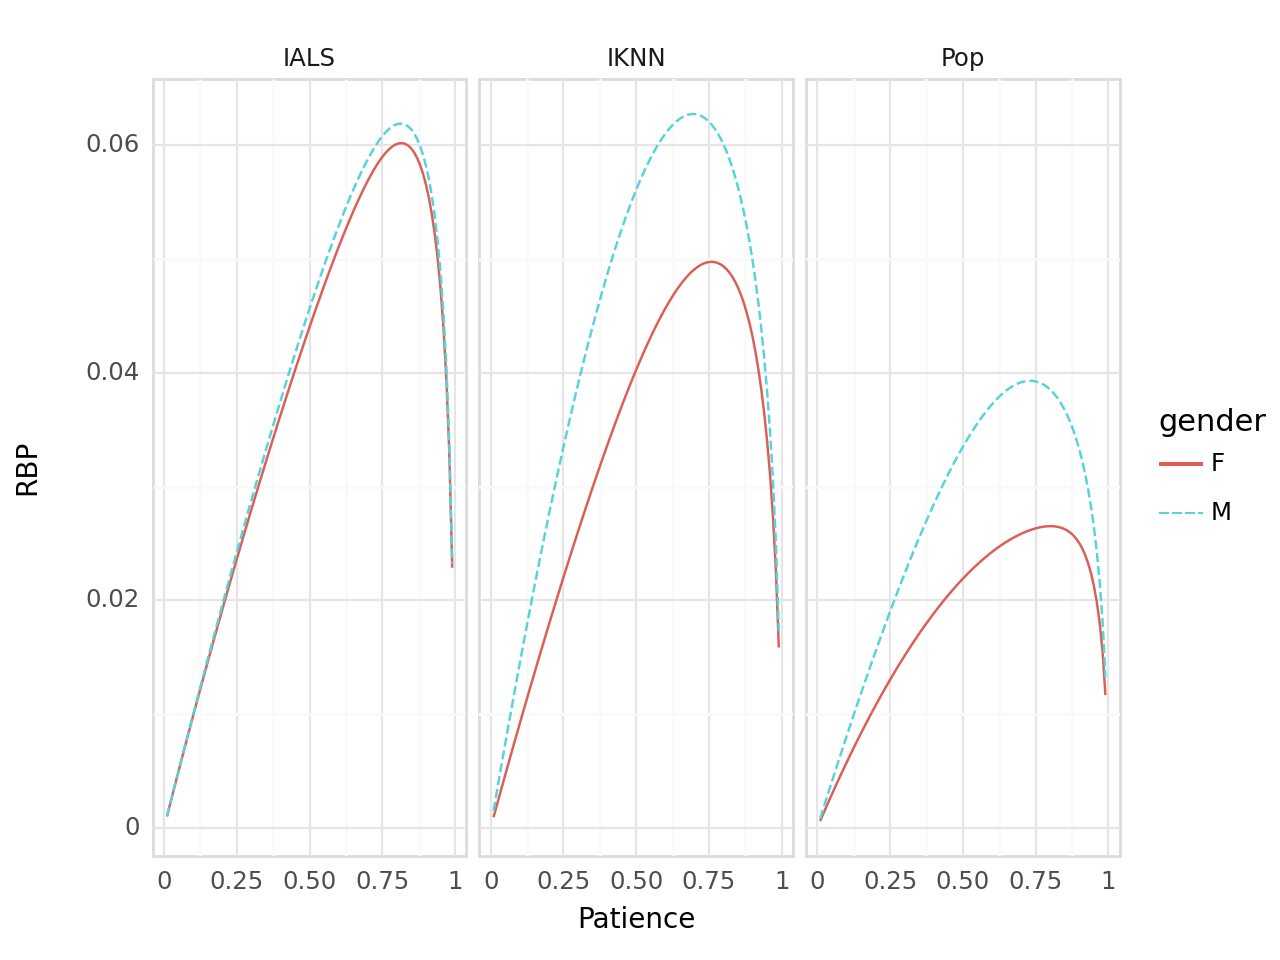

<Figure Size: (640 x 480)>

In [74]:
make_plot(
    ag_rbp,
    pn.aes(x='patience', y='RBP', color='gender', linetype='gender'),
    pn.geom_line(),
    pn.facet_grid('~ algo'),
    pn.xlab('Patience'),
    file='rbp-uncertain-gender-response.png',
    width=9,
    height=3,
)

The Bayes thing:


In [75]:
ag_rbp['weight'] = bm_dist.pdf(ag_rbp['patience']) * p_res
prbp_cdf = ag_rbp.groupby(['algo', 'gender']).apply(lambda df: df.sort_values('RBP')['weight'].cumsum())
prbp_cdf.reset_index(['algo', 'gender'], inplace=True, drop=True)
ag_rbp['cdf'] = prbp_cdf
ag_rbp

,algo,gender,patience,RBP,weight,cdf
0,IALS,M,0.01,0.001011,2.970000e-09,2.970000e-09
1,IALS,M,0.02,0.002020,4.704000e-08,5.001000e-08
2,IALS,M,0.03,0.003025,2.357100e-07,2.857200e-07
3,IALS,M,0.04,0.004027,7.372800e-07,1.023000e-06
4,IALS,M,0.05,0.005026,1.781250e-06,2.804250e-06
...,...,...,...,...,...,...
589,Pop,F,0.95,0.021332,1.221759e-02,1.264265e-01
590,Pop,F,0.96,0.019927,1.019216e-02,8.613389e-02
591,Pop,F,0.97,0.018090,7.967635e-03,4.695968e-02
592,Pop,F,0.98,0.015564,5.534209e-03,2.213006e-02


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 2 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/UserDists/rbp-uncertain-gender-post.png


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


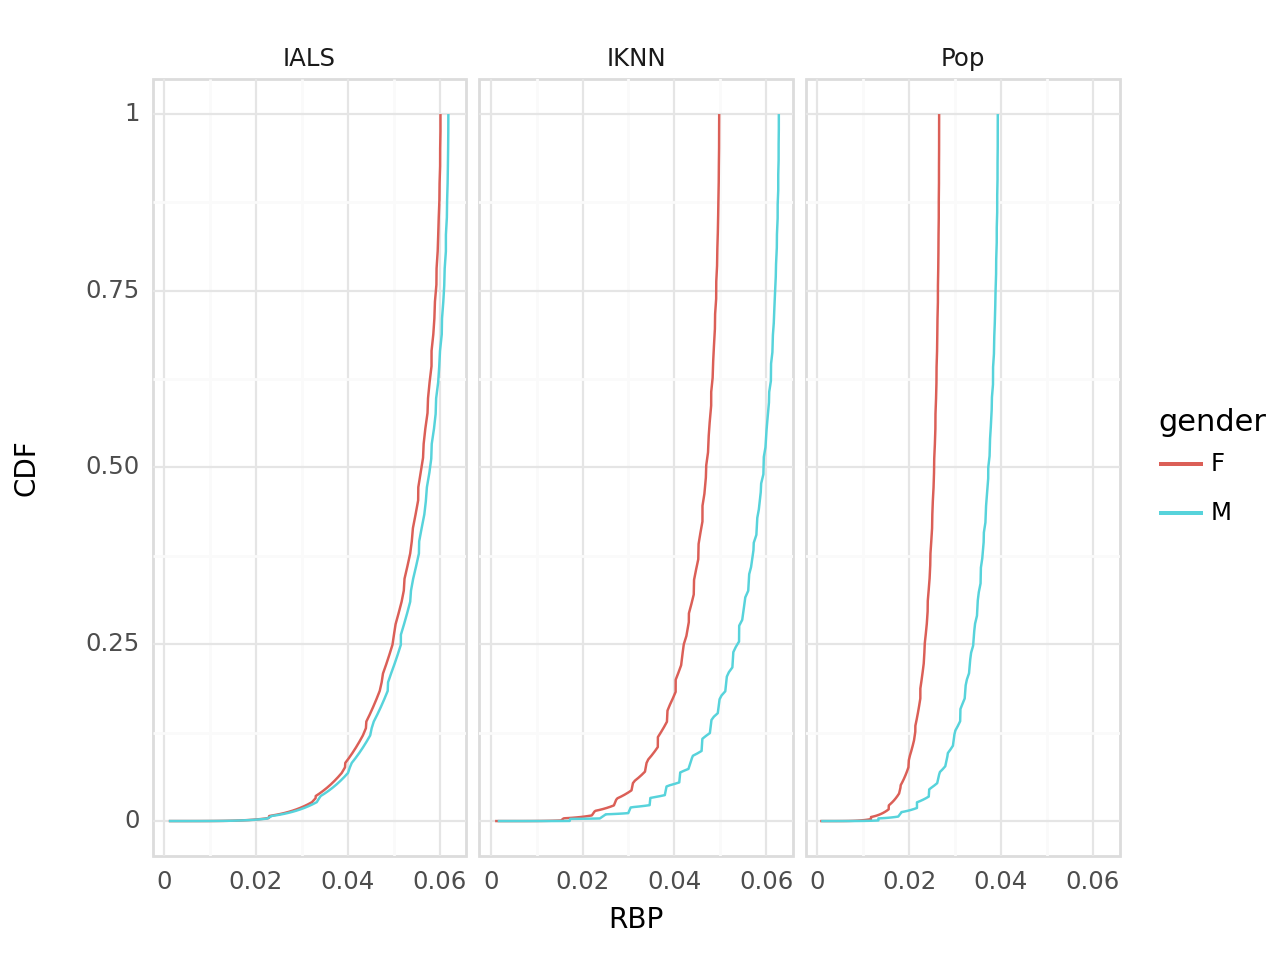

<Figure Size: (640 x 480)>

In [76]:
make_plot(
    ag_rbp,
    pn.aes(x='RBP', y='cdf', color='gender'),
    pn.geom_line(),
    pn.facet_grid('~ algo'),
    pn.ylab('CDF'),
    file='rbp-uncertain-gender-post.png',
    width=4.5,
    height=2,
)